In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set timezone for date handling
# ist = pytz.timezone('Asia/Kolkata')

Mounted at /content/drive


# **DATA Loading and Initial Inspection**

In [ ]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Crypto-data-v3/Solana_Price_data.csv')

# Convert to datetime with correct timezone
# df['date'] = pd.to_datetime(df['date'], dayfirst=True).dt.tz_localize(ist)
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

# Sort chronologically
df = df.sort_values('date').reset_index(drop=True)
df['Volume'] = df['Volume'].astype(float)



In [ ]:

# Save raw version
df.to_csv('/content/drive/MyDrive/Crypto-data-v3/1_raw_data.csv', index=False)

In [ ]:
# 1.2 Verify data types
print("Data Types:")
print(df.dtypes)
print("\n")

Data Types:
date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume           float64
dtype: object




In [ ]:
print("Time Period Coverage:")
print(f"Start Date: {df['date'].min()}")
print(f"End Date: {df['date'].max()}")
print(f"Total Days: {df.shape[0]}")
print(f"Expected Days: {pd.to_datetime(df['date'].max()) - pd.to_datetime(df['date'].min())}")
print("\n")

Time Period Coverage:
Start Date: 2021-01-01 00:00:00
End Date: 2025-04-15 00:00:00
Total Days: 1566
Expected Days: 1565 days 00:00:00




In [ ]:
# 1.4 Examine basic statistics
print("Basic Statistics:")
print(df.describe())

Basic Statistics:
                                date         Open         High          Low  \
count                           1566  1566.000000  1566.000000  1566.000000   
mean   2023-02-22 11:59:59.999999744    86.679205    90.334138    82.992892   
min              2021-01-01 00:00:00     1.510000     1.865000     1.495000   
25%              2022-01-27 06:00:00    23.970000    24.932500    22.935000   
50%              2023-02-22 12:00:00    56.845000    59.470000    53.790000   
75%              2024-03-19 18:00:00   144.467500   149.702500   139.587500   
max              2025-04-15 00:00:00   261.970000   295.830000   252.690000   
std                              NaN    69.515905    72.111304    66.729900   

             Close        Volume  
count  1566.000000  1.566000e+03  
mean     86.759976  2.078157e+09  
min       1.799000  2.572255e+07  
25%      23.980000  5.006599e+08  
50%      56.940000  1.479582e+09  
75%     144.467500  2.808882e+09  
max     261.970000  3.317

In [ ]:
print("\nData Sample:")
print(df.head())


Data Sample:
        date   Open   High    Low  Close      Volume
0 2021-01-01  1.510  1.865  1.495  1.847  25722549.0
1 2021-01-02  1.847  2.012  1.752  1.799  31671064.0
2 2021-01-03  1.799  2.808  2.007  2.185  55073422.0
3 2021-01-04  2.185  2.573  2.066  2.491  59955405.0
4 2021-01-05  2.491  2.634  2.145  2.158  50555207.0


In [ ]:
# 1.6 Check for any initial NULL values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


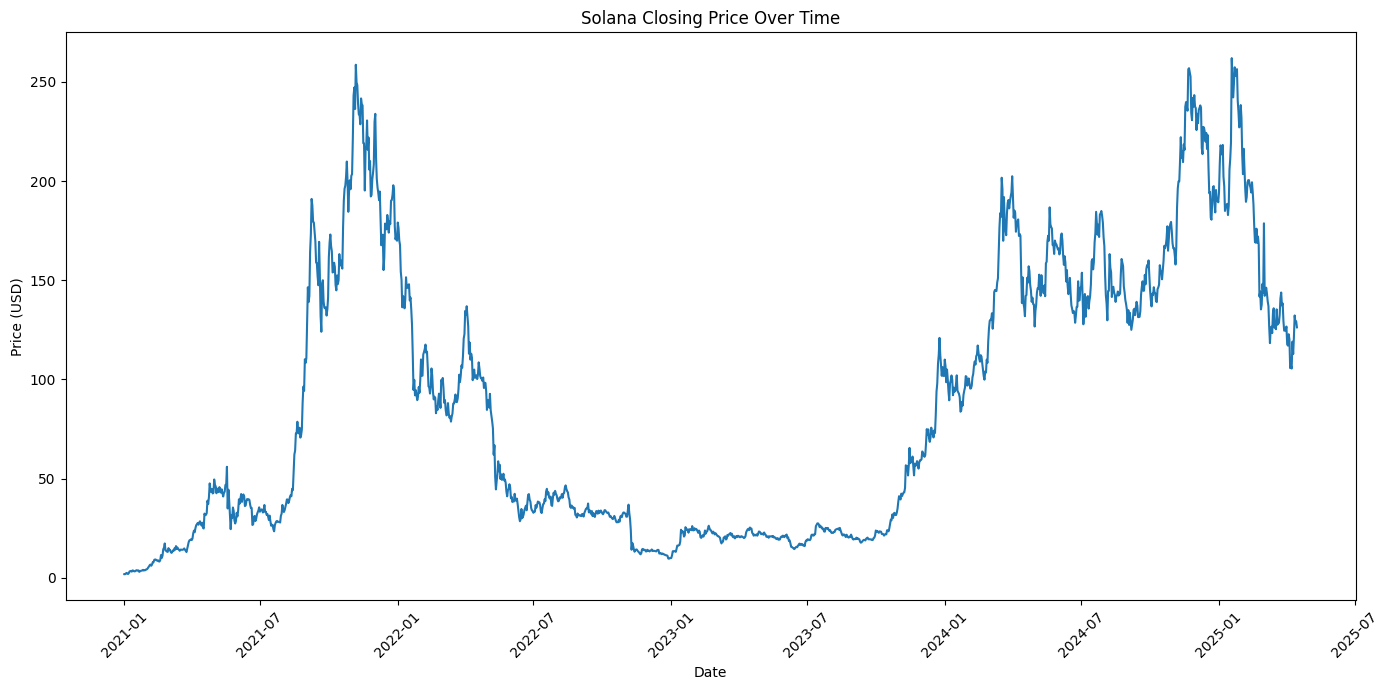

In [ ]:


# 1.7 Visualize the closing price over time to get an initial understanding
plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['Close'])
plt.title('Solana Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

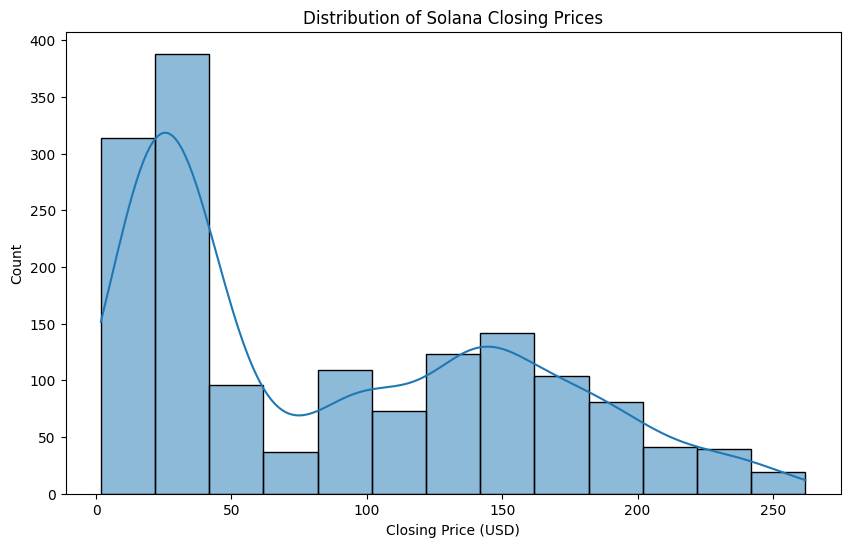

In [ ]:
# 1.8 Check the distribution of closing prices
plt.figure(figsize=(10, 6))
sns.histplot(df['Close'], kde=True)
plt.title('Distribution of Solana Closing Prices')
plt.xlabel('Closing Price (USD)')
plt.show()

# **DATA Analysis and Treatment**

In [ ]:
# 2.1. Set the datetime column as the index
df.set_index('date', inplace=True)

In [ ]:
# 2.2. Verify the index is datetime
print("Index Type:", type(df.index))
# Get information about the DatetimeIndex
print("Index Info:")
print(df.index)  # Print the index itself
print("Index Data Type:", df.index.dtype)  # Get data type of the index
print("Index Frequency:", df.index.freq)  # Check if index has a frequency
# Check if index is monotonic using alternative method for older Pandas versions
print("Index is Monotonic:", df.index.is_monotonic_increasing or df.index.is_monotonic_decreasing)
print("Index is Unique:", df.index.is_unique)  # Check if index values are unique

Index Type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index Info:
DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2025-04-06', '2025-04-07', '2025-04-08', '2025-04-09',
               '2025-04-10', '2025-04-11', '2025-04-12', '2025-04-13',
               '2025-04-14', '2025-04-15'],
              dtype='datetime64[ns]', name='date', length=1566, freq=None)
Index Data Type: datetime64[ns]
Index Frequency: None
Index is Monotonic: True
Index is Unique: True


In [ ]:
# 2.3. Sort data chronologically to ensure proper time order
df = df.sort_index()

In [ ]:
# 2.4. Check the frequency of the data
# For daily data we expect a frequency of 'D' or business day 'B'
print("\nIndex Frequency:")
if df.index.inferred_freq is not None:
    print(f"Inferred Frequency: {df.index.inferred_freq}")
else:
    print("No regular frequency detected. Checking for missing dates...")


Index Frequency:
Inferred Frequency: D


In [ ]:
full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
missing_dates = full_date_range.difference(df.index)

if len(missing_dates) > 0:
    print(f"Missing {len(missing_dates)} dates in the time series.")
    print("First few missing dates:")
    print(missing_dates[:5])
else:
    print("No missing dates detected. The time series is continuous.")

No missing dates detected. The time series is continuous.


In [ ]:
# 2.5. Check for duplicate dates
duplicates = df.index.duplicated()
if duplicates.any():
    print(f"\nFound {duplicates.sum()} duplicate dates in the index")
    print("First few duplicates:")
    print(df[df.index.duplicated(keep=False)].head())
else:
    print("\nNo duplicate dates found in the index")


No duplicate dates found in the index


In [ ]:
# 2.6. Convert timezone if needed (optional - if you want UTC or a specific timezone)
# If you want to standardize to UTC:
print("\nCurrent timezone:", df.index.tz)
df.index = df.index.tz_localize('UTC')
print("New timezone:", df.index.tz)


Current timezone: None
New timezone: UTC


In [ ]:
print("Current index (first few entries):")
print(df.index[:5])

Current index (first few entries):
DatetimeIndex(['2021-01-01 00:00:00+00:00', '2021-01-02 00:00:00+00:00',
               '2021-01-03 00:00:00+00:00', '2021-01-04 00:00:00+00:00',
               '2021-01-05 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='date', freq=None)


In [ ]:
df.columns = df.columns.str.strip()


In [ ]:
# 2.7. Display the updated dataframe
print("\nUpdated DataFrame with datetime index:")
print(df.head())


Updated DataFrame with datetime index:
                            Open   High    Low  Close      Volume
date                                                             
2021-01-01 00:00:00+00:00  1.510  1.865  1.495  1.847  25722549.0
2021-01-02 00:00:00+00:00  1.847  2.012  1.752  1.799  31671064.0
2021-01-03 00:00:00+00:00  1.799  2.808  2.007  2.185  55073422.0
2021-01-04 00:00:00+00:00  2.185  2.573  2.066  2.491  59955405.0
2021-01-05 00:00:00+00:00  2.491  2.634  2.145  2.158  50555207.0


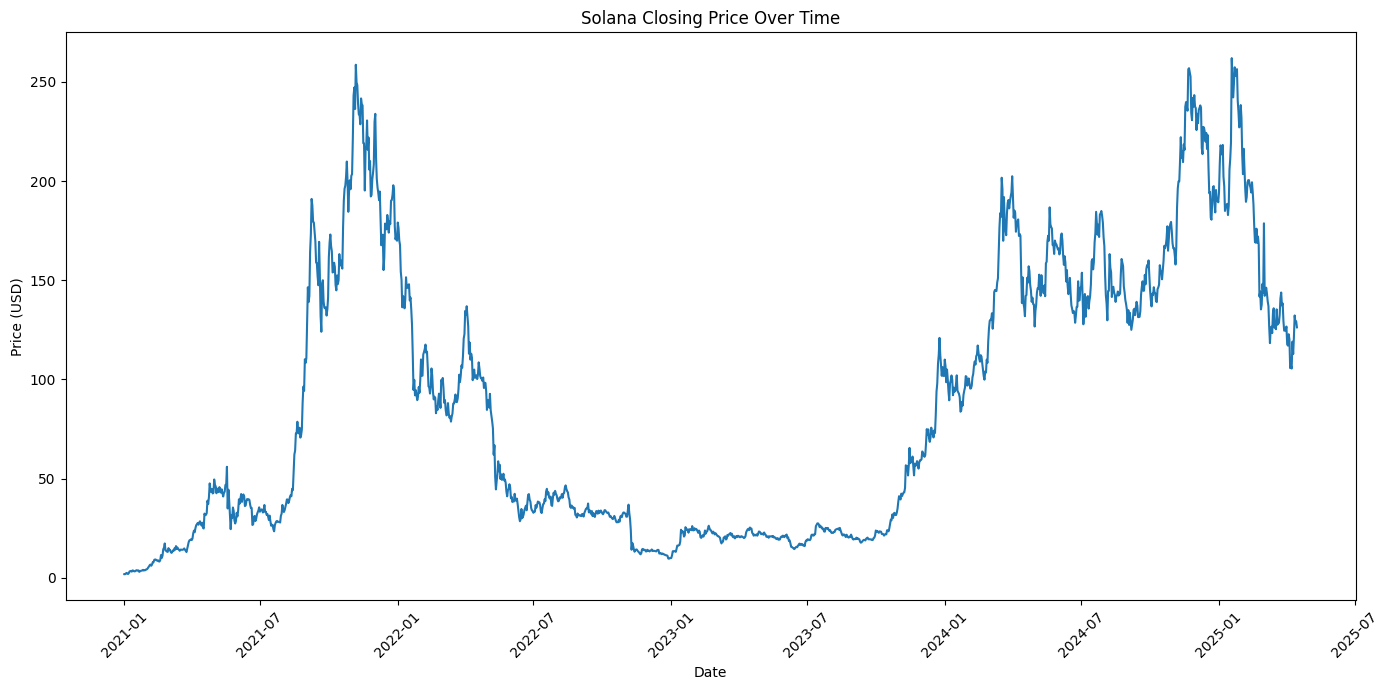

In [ ]:
# 2.8. Visualize the closing price with proper datetime index
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'])
plt.title('Solana Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
df.to_csv('/content/drive/MyDrive/Crypto-data-v3/step2_handling-time-index_data.csv', index=True)
# df_new = pd.read_csv('/content/drive/MyDrive/Crypto-data-v3/step2_handling-time-index_data.csv')

In [ ]:
print("\nCurrent timezone:", df.index.tz)
df.head()


Current timezone: UTC


,Open,High,Low,Close,Volume
date,,,,,
2021-01-01 00:00:00+00:00,1.510,1.865,1.495,1.847,25722549.0
2021-01-02 00:00:00+00:00,1.847,2.012,1.752,1.799,31671064.0
2021-01-03 00:00:00+00:00,1.799,2.808,2.007,2.185,55073422.0
2021-01-04 00:00:00+00:00,2.185,2.573,2.066,2.491,59955405.0
2021-01-05 00:00:00+00:00,2.491,2.634,2.145,2.158,50555207.0


# **DATA Engineering**

In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/Crypto-data-v3/step2_handling-time-index_data.csv')

In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=e030cfd0e360bafbac199d7d7df23320c05021404c06b527d59554d94289bf09
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [ ]:
from ta import add_all_ta_features
from ta.utils import dropna
# import talib

In [ ]:
df['Returns'] = df['Close'].pct_change()
df['Returns_Abs'] = np.abs(df['Returns'])
df['Volatility_14d'] = df['Returns'].rolling(window=14).std().shift(1)
df['Volume_Ratio'] = df['Volume'] / df['Volume'].shift(1).rolling(window=20).mean()
df['Extreme_Move'] = (np.abs(df['Returns'].shift(1)) > 0.10).astype(int)

In [ ]:
df.head()
print(df.dtypes)

Open              float64
High              float64
Low               float64
Close             float64
Volume            float64
Returns           float64
Returns_Abs       float64
Volatility_14d    float64
Volume_Ratio      float64
Extreme_Move        int64
dtype: object


In [ ]:
# 5.1. Create lagged features
print("Creating lagged features...")
# Create lagged price features
for lag in [1, 2, 3, 5, 7, 14, 21]:
    df[f'Close_Lag_{lag}'] = df['Close'].shift(lag)
    df[f'Volume_Lag_{lag}'] = df['Volume'].shift(lag)
    df[f'Returns_Lag_{lag}'] = df['Returns'].shift(lag)





Creating lagged features...


In [ ]:
# 5.2. Calculate moving averages
print("Calculating moving averages...")
for window in [5, 10, 20, 50, 100, 200]:
    # Simple Moving Averages
    df[f'SMA_{window}'] = df['Close'].rolling(window=window).mean()

    # Exponential Moving Averages
    df[f'EMA_{window}'] = df['Close'].ewm(span=window, adjust=False).mean()

    # Volume Moving Averages
    df[f'Volume_SMA_{window}'] = df['Volume'].rolling(window=window).mean()

Calculating moving averages...


In [ ]:
# 5.3. Calculate price momentum indicators
print("Calculating momentum indicators...")
# Rate of Change (ROC)
for period in [5, 10, 20]:
    df[f'ROC_{period}'] = df['Close'].pct_change(periods=period) * 100

# Moving Average Convergence Divergence (MACD)
df['MACD_Line'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
df['MACD_Signal'] = df['MACD_Line'].ewm(span=9, adjust=False).mean()
df['MACD_Hist'] = df['MACD_Line'] - df['MACD_Signal']

# Relative Strength Index (RSI)
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

rs = avg_gain / avg_loss
df['RSI_14'] = 100 - (100 / (1 + rs))

# Williams %R
highest_high = df['High'].rolling(window=14).max()
lowest_low = df['Low'].rolling(window=14).min()
df['Williams_%R'] = ((highest_high - df['Close']) / (highest_high - lowest_low)) * -100

Calculating momentum indicators...


In [ ]:
# 5.4. Calculate volatility indicators
print("Calculating volatility indicators...")
# Bollinger Bands
for window in [20]:
    rolling_mean = df['Close'].rolling(window=window).mean()
    rolling_std = df['Close'].rolling(window=window).std()

    df[f'BB_Upper_{window}'] = rolling_mean + (rolling_std * 2)
    df[f'BB_Middle_{window}'] = rolling_mean
    df[f'BB_Lower_{window}'] = rolling_mean - (rolling_std * 2)
    df[f'BB_Width_{window}'] = (df[f'BB_Upper_{window}'] - df[f'BB_Lower_{window}']) / df[f'BB_Middle_{window}']

# Average True Range (ATR)
high_low = df['High'] - df['Low']
high_close = np.abs(df['High'] - df['Close'].shift())
low_close = np.abs(df['Low'] - df['Close'].shift())

true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
df['ATR_14'] = true_range.rolling(window=14).mean()

Calculating volatility indicators...


In [ ]:
# 5.5. Create cyclical features from date
print("Creating cyclical features...")
# Extract datetime components
df['Day_of_Week'] = df.index.dayofweek
df['Month'] = df.index.month
df['Quarter'] = df.index.quarter
df['Year'] = df.index.year
df['Day_of_Month'] = df.index.day
df['Week_of_Year'] = df.index.isocalendar().week

# Convert cyclical features to sine and cosine components to preserve cyclical nature
for col in ['Day_of_Week', 'Month', 'Quarter']:
    # Sine and cosine transformations
    max_val = df[col].max()
    df[f'{col}_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[f'{col}_cos'] = np.cos(2 * np.pi * df[col] / max_val)

Creating cyclical features...


In [ ]:
# 5.6. Create interaction features
print("Creating interaction features...")
# Price and volume interactions
df['Price_Volume_Ratio'] = df['Close'] / (df['Volume'] + 1)  # Adding 1 to avoid division by zero
df['Price_Volume_SMA10_Ratio'] = df['SMA_10'] / (df['Volume_SMA_10'] + 1)

# Volatility and price interactions
df['ATR_Close_Ratio'] = df['ATR_14'] / df['Close']


Creating interaction features...


In [ ]:
# 5.7. Create binary indicators
print("Creating binary indicators...")
# Golden Cross / Death Cross (50-day MA crossing 200-day MA)
df['SMA_50_Above_SMA_200'] = (df['SMA_50'] > df['SMA_200']).astype(int)
df['SMA_Golden_Cross'] = ((df['SMA_50'] > df['SMA_200']) & (df['SMA_50'].shift() <= df['SMA_200'].shift())).astype(int)
df['SMA_Death_Cross'] = ((df['SMA_50'] < df['SMA_200']) & (df['SMA_50'].shift() >= df['SMA_200'].shift())).astype(int)

# RSI Overbought/Oversold
df['RSI_Overbought'] = (df['RSI_14'] > 70).astype(int)
df['RSI_Oversold'] = (df['RSI_14'] < 30).astype(int)

# Price above/below moving averages
df['Price_Above_SMA_200'] = (df['Close'] > df['SMA_200']).astype(int)
df['Price_Above_SMA_50'] = (df['Close'] > df['SMA_50']).astype(int)

# Higher highs and lower lows (trend strength)
df['Higher_High'] = (df['High'] > df['High'].shift()).astype(int)
df['Lower_Low'] = (df['Low'] < df['Low'].shift()).astype(int)


Creating binary indicators...


In [ ]:
# 5.8. Calculate support and resistance levels
print("Calculating support and resistance levels...")
# Simple support/resistance based on recent highs and lows
df['Support_Level'] = df['Low'].rolling(window=20).min()
df['Resistance_Level'] = df['High'].rolling(window=20).max()
df['Price_to_Support_Ratio'] = df['Close'] / df['Support_Level']
df['Price_to_Resistance_Ratio'] = df['Close'] / df['Resistance_Level']

Calculating support and resistance levels...


In [ ]:
# 5.9. Add market structure features
print("Adding market structure features...")
# Calculate if price is in range or trending
df['20d_High'] = df['High'].rolling(window=20).max()
df['20d_Low'] = df['Low'].rolling(window=20).min()
df['Price_Range_Width'] = (df['20d_High'] - df['20d_Low']) / df['Close']
df['In_Range_Market'] = ((df['Price_Range_Width'] < 0.25) & (df['Volatility_14d'] < df['Volatility_14d'].rolling(window=30).mean())).astype(int)

# Calculate specific crypto-related features
# Count days since ATH (All-Time High)
df['ATH'] = df['Close'].cummax()
df['Days_Since_ATH'] = df['Close'].cummax().ne(df['Close'].cummax().shift()).cumsum()
df['ATH_Drawdown'] = (df['Close'] / df['ATH'] - 1) * 100  # Negative percentage from ATH

Adding market structure features...


In [ ]:
constant_features = [col for col in df.columns if df[col].nunique() <= 1]
if constant_features:
    print(f"Found {len(constant_features)} constant features (zero variance). These will be removed:")
    print(constant_features[:5], "..." if len(constant_features) > 5 else "")

    # Remove constant features
    df.drop(columns=constant_features)
    print(f"Shapes after removing constant features - dataset: {df.shape}")
else:
    print("No constant features found.")



No constant features found.


In [ ]:
# 5.10. Add log-transformed features (especially useful for volume)
print("Adding log-transformed features...")
df['Log_Close'] = np.log(df['Close'])
df['Log_Volume'] = np.log(df['Volume'] + 1)  # Adding 1 to avoid log(0)

Adding log-transformed features...


Visualizing key features...


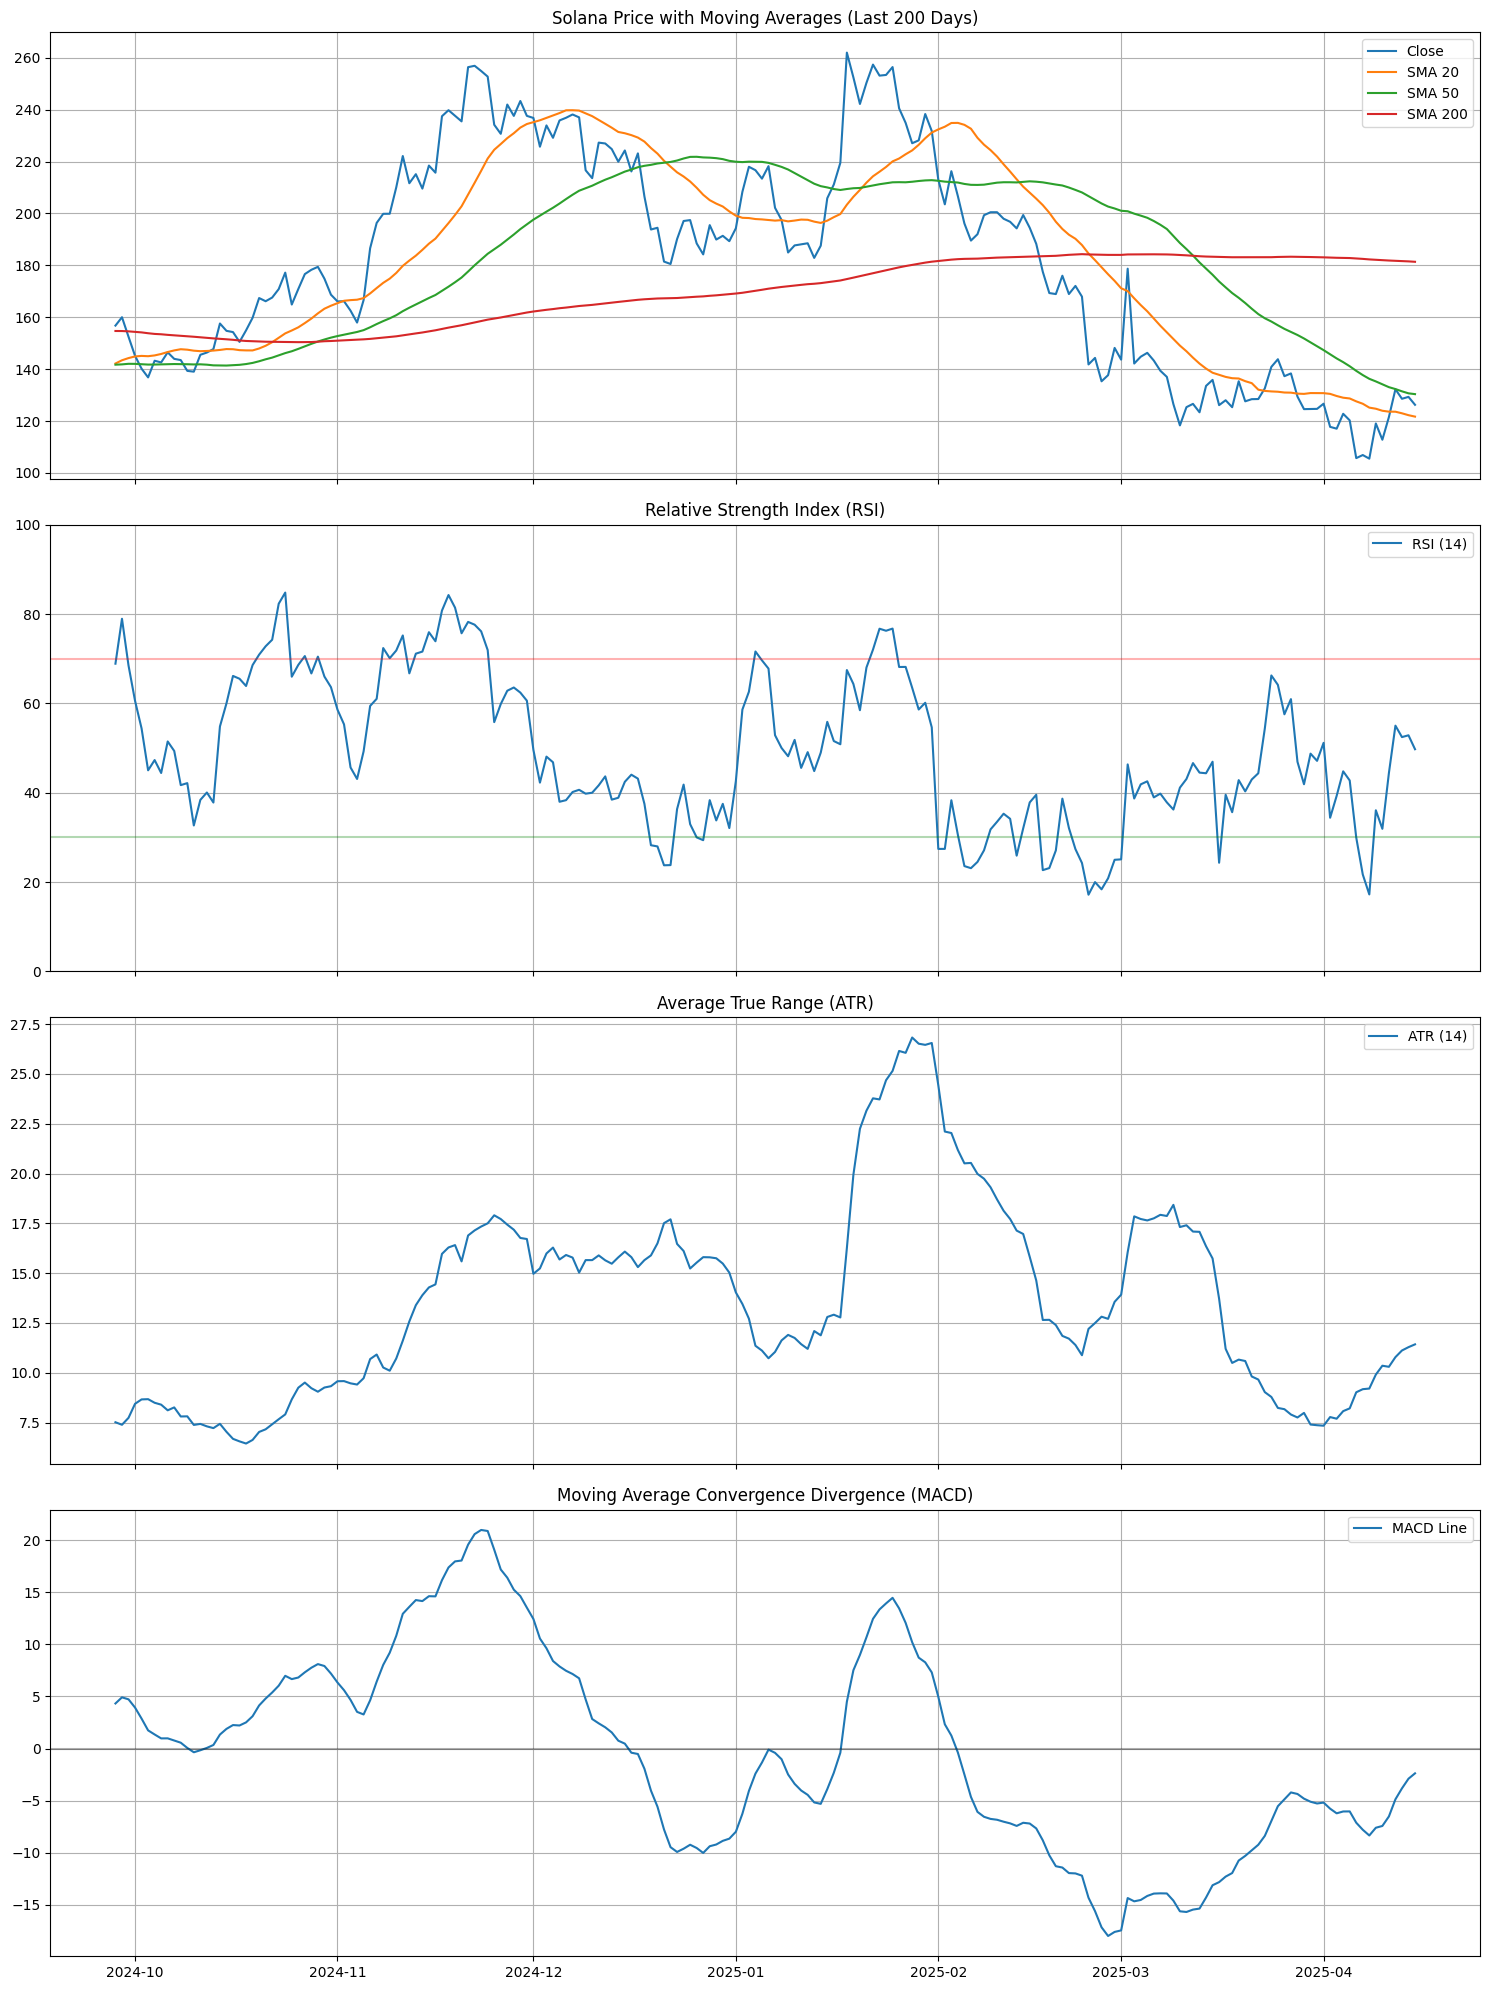

In [ ]:
# 5.11. Visualize key features
print("Visualizing key features...")
# Select a subset of important features for plotting
key_features = ['Close', 'SMA_20', 'SMA_50', 'SMA_200', 'RSI_14', 'ATR_14', 'MACD_Line']
last_200_days = df[key_features].tail(200)

# Create the plots
fig, axes = plt.subplots(4, 1, figsize=(15, 20), sharex=True)

# Plot 1: Price and Moving Averages
axes[0].plot(last_200_days.index, last_200_days['Close'], label='Close')
axes[0].plot(last_200_days.index, last_200_days['SMA_20'], label='SMA 20')
axes[0].plot(last_200_days.index, last_200_days['SMA_50'], label='SMA 50')
axes[0].plot(last_200_days.index, last_200_days['SMA_200'], label='SMA 200')
axes[0].set_title('Solana Price with Moving Averages (Last 200 Days)')
axes[0].legend()
axes[0].grid(True)

# Plot 2: RSI
axes[1].plot(last_200_days.index, last_200_days['RSI_14'], label='RSI (14)')
axes[1].axhline(y=70, color='r', linestyle='-', alpha=0.3)
axes[1].axhline(y=30, color='g', linestyle='-', alpha=0.3)
axes[1].set_title('Relative Strength Index (RSI)')
axes[1].set_ylim(0, 100)
axes[1].legend()
axes[1].grid(True)

# Plot 3: ATR
axes[2].plot(last_200_days.index, last_200_days['ATR_14'], label='ATR (14)')
axes[2].set_title('Average True Range (ATR)')
axes[2].legend()
axes[2].grid(True)

# Plot 4: MACD
axes[3].plot(last_200_days.index, last_200_days['MACD_Line'], label='MACD Line')
axes[3].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes[3].set_title('Moving Average Convergence Divergence (MACD)')
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# 5.12. Print feature summary
print("\nFeature Engineering Summary:")
print(f"Original features: 5 (Open, High, Low, Close, Volume)")
print(f"Engineered features: {df.shape[1] - 5}")
print(f"Total features: {df.shape[1]}")

# Group features by category for better understanding
lag_features = [col for col in df.columns if 'Lag' in col]
ma_features = [col for col in df.columns if 'SMA_' in col or 'EMA_' in col]
momentum_features = [col for col in df.columns if any(x in col for x in ['RSI', 'MACD', 'ROC', 'Williams'])]
volatility_features = [col for col in df.columns if any(x in col for x in ['ATR', 'BB_', 'Volatility'])]
cyclical_features = [col for col in df.columns if any(x in col for x in ['Day_of', 'Month', 'Quarter', 'Year', 'Week_of', '_sin', '_cos'])]
binary_features = [col for col in df.columns if any(x in col for x in ['Above', 'Cross', 'Overbought', 'Oversold', 'Higher', 'Lower'])]

print(f"\nLagged features: {len(lag_features)}")
print(f"Moving average features: {len(ma_features)}")
print(f"Momentum features: {len(momentum_features)}")
print(f"Volatility features: {len(volatility_features)}")
print(f"Cyclical features: {len(cyclical_features)}")
print(f"Binary/indicator features: {len(binary_features)}")


Feature Engineering Summary:
Original features: 5 (Open, High, Low, Close, Volume)
Engineered features: 94
Total features: 99

Lagged features: 21
Moving average features: 23
Momentum features: 10
Volatility features: 7
Cyclical features: 12
Binary/indicator features: 10


In [ ]:
# 5.13. Check for any issues in the engineered features
print("\nChecking for NaN values in engineered features:")
nan_counts = df.isna().sum()
features_with_nans = nan_counts[nan_counts > 0]
print(features_with_nans)

print("\nNote: NaN values at the beginning of time series are expected due to calculation methods")
print("requiring historical data (e.g., 200-day moving averages need 200 days of data).")



Checking for NaN values in engineered features:
Returns                        1
Returns_Abs                    1
Volatility_14d                15
Volume_Ratio                  20
Close_Lag_1                    1
Volume_Lag_1                   1
Returns_Lag_1                  2
Close_Lag_2                    2
Volume_Lag_2                   2
Returns_Lag_2                  3
Close_Lag_3                    3
Volume_Lag_3                   3
Returns_Lag_3                  4
Close_Lag_5                    5
Volume_Lag_5                   5
Returns_Lag_5                  6
Close_Lag_7                    7
Volume_Lag_7                   7
Returns_Lag_7                  8
Close_Lag_14                  14
Volume_Lag_14                 14
Returns_Lag_14                15
Close_Lag_21                  21
Volume_Lag_21                 21
Returns_Lag_21                22
SMA_5                          4
Volume_SMA_5                   4
SMA_10                         9
Volume_SMA_10              

In [ ]:
df.head()

,Open,High,Low,Close,Volume,Returns,Returns_Abs,Volatility_14d,Volume_Ratio,Extreme_Move,...,Price_to_Resistance_Ratio,20d_High,20d_Low,Price_Range_Width,In_Range_Market,ATH,Days_Since_ATH,ATH_Drawdown,Log_Close,Log_Volume
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,1.510,1.865,1.495,1.847,25722549.0,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,0,1.847,1,0.000000,0.613563,17.062879
2021-01-02 00:00:00+00:00,1.847,2.012,1.752,1.799,31671064.0,-0.025988,0.025988,NaN,NaN,0,...,NaN,NaN,NaN,NaN,0,1.847,1,-2.598809,0.587231,17.270914
2021-01-03 00:00:00+00:00,1.799,2.808,2.007,2.185,55073422.0,0.214564,0.214564,NaN,NaN,0,...,NaN,NaN,NaN,NaN,0,2.185,2,0.000000,0.781616,17.824178
2021-01-04 00:00:00+00:00,2.185,2.573,2.066,2.491,59955405.0,0.140046,0.140046,NaN,NaN,1,...,NaN,NaN,NaN,NaN,0,2.491,3,0.000000,0.912684,17.909112
2021-01-05 00:00:00+00:00,2.491,2.634,2.145,2.158,50555207.0,-0.133681,0.133681,NaN,NaN,1,...,NaN,NaN,NaN,NaN,0,2.491,3,-13.368125,0.769182,17.738577


In [ ]:
df = df.dropna().copy()


In [ ]:
nan_counts = df.isna().sum()
features_with_nans = nan_counts[nan_counts > 0]
print(features_with_nans)

Series([], dtype: int64)


In [ ]:
df.head()

,Open,High,Low,Close,Volume,Returns,Returns_Abs,Volatility_14d,Volume_Ratio,Extreme_Move,...,Price_to_Resistance_Ratio,20d_High,20d_Low,Price_Range_Width,In_Range_Market,ATH,Days_Since_ATH,ATH_Drawdown,Log_Close,Log_Volume
date,,,,,,,,,,,,,,,,,,,,,
2021-07-19 00:00:00+00:00,26.67,26.70,24.01,24.50,361915410.0,-0.081365,0.081365,0.057010,1.020097,0,...,0.643045,38.1,24.01,0.575102,0,55.98,43,-56.234369,3.198673,19.706921
2021-07-20 00:00:00+00:00,24.50,24.98,22.12,23.46,413439963.0,-0.042449,0.042449,0.059341,1.183664,0,...,0.615748,38.1,22.12,0.681159,0,55.98,43,-58.092176,3.155297,19.840023
2021-07-21 00:00:00+00:00,23.46,27.45,22.83,26.63,555770206.0,0.135124,0.135124,0.057102,1.627863,0,...,0.698950,38.1,22.12,0.600075,0,55.98,43,-52.429439,3.282038,20.135865
2021-07-22 00:00:00+00:00,26.63,28.18,25.94,27.71,364666998.0,0.040556,0.040556,0.066915,1.055579,1,...,0.727297,38.1,22.12,0.576687,0,55.98,43,-50.500179,3.321793,19.714495
2021-07-23 00:00:00+00:00,27.71,28.70,26.41,28.51,407955237.0,0.028870,0.028870,0.064858,1.193953,0,...,0.748294,38.1,22.12,0.560505,0,55.98,43,-49.071097,3.350255,19.826668


In [ ]:
df.columns.to_list()


['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'Returns',
 'Returns_Abs',
 'Volatility_14d',
 'Volume_Ratio',
 'Extreme_Move',
 'Close_Lag_1',
 'Volume_Lag_1',
 'Returns_Lag_1',
 'Close_Lag_2',
 'Volume_Lag_2',
 'Returns_Lag_2',
 'Close_Lag_3',
 'Volume_Lag_3',
 'Returns_Lag_3',
 'Close_Lag_5',
 'Volume_Lag_5',
 'Returns_Lag_5',
 'Close_Lag_7',
 'Volume_Lag_7',
 'Returns_Lag_7',
 'Close_Lag_14',
 'Volume_Lag_14',
 'Returns_Lag_14',
 'Close_Lag_21',
 'Volume_Lag_21',
 'Returns_Lag_21',
 'SMA_5',
 'EMA_5',
 'Volume_SMA_5',
 'SMA_10',
 'EMA_10',
 'Volume_SMA_10',
 'SMA_20',
 'EMA_20',
 'Volume_SMA_20',
 'SMA_50',
 'EMA_50',
 'Volume_SMA_50',
 'SMA_100',
 'EMA_100',
 'Volume_SMA_100',
 'SMA_200',
 'EMA_200',
 'Volume_SMA_200',
 'ROC_5',
 'ROC_10',
 'ROC_20',
 'MACD_Line',
 'MACD_Signal',
 'MACD_Hist',
 'RSI_14',
 'Williams_%R',
 'BB_Upper_20',
 'BB_Middle_20',
 'BB_Lower_20',
 'BB_Width_20',
 'ATR_14',
 'Day_of_Week',
 'Month',
 'Quarter',
 'Year',
 'Day_of_Month',
 'Week_of_Year',
 'Day_

In [ ]:
# 5.14. Save the engineered dataset
df.to_csv('/content/drive/MyDrive/Crypto-data-v3/step3_feature_engineering.csv', index=True, index_label='date')
print("\nEngineered dataset saved as 'step3_feature_engineering.csv'")


Engineered dataset saved as 'step3_feature_engineering.csv'


In [ ]:
# 5.15. Print first few rows of the final dataset with key features
print("\nSample of final dataset with key engineered features:")
key_display_features = ['Close', 'Volume', 'Returns', 'SMA_20', 'SMA_50', 'RSI_14', 'MACD_Line', 'ATR_14']
print(df[key_display_features].head())


Sample of final dataset with key engineered features:
                           Close       Volume   Returns   SMA_20   SMA_50  \
date                                                                        
2021-07-19 00:00:00+00:00  24.50  361915410.0 -0.081365  31.4950  33.9750   
2021-07-20 00:00:00+00:00  23.46  413439963.0 -0.042449  30.8915  33.7886   
2021-07-21 00:00:00+00:00  26.63  555770206.0  0.135124  30.5570  33.7016   
2021-07-22 00:00:00+00:00  27.71  364666998.0  0.040556  30.2425  33.5762   
2021-07-23 00:00:00+00:00  28.51  407955237.0  0.028870  29.9430  33.3552   

                              RSI_14  MACD_Line    ATR_14  
date                                                       
2021-07-19 00:00:00+00:00  31.439894  -2.152215  2.782143  
2021-07-20 00:00:00+00:00  26.013363  -2.422425  2.835000  
2021-07-21 00:00:00+00:00  28.188500  -2.353644  2.861429  
2021-07-22 00:00:00+00:00  36.839554  -2.186780  2.717143  
2021-07-23 00:00:00+00:00  38.740009  -1.9673

# **DATA Splitting**

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

In [ ]:
print("Step 4: Feature Scaling/Normalization")

# 4.1. First, let's separate our target variable and features
# Assuming our target is the 'Close' price
target_column = 'Close'
features = df.drop(columns=[target_column])


Step 4: Feature Scaling/Normalization


In [ ]:
# 4.2. Split data chronologically into train and validation sets
# Time series requires chronological splitting - don't shuffle!
train_size = 0.8  # Use 80% of data for training
split_idx = int(len(df) * train_size)

# Split features and target
X_train = features.iloc[:split_idx]
X_valid = features.iloc[split_idx:]
y_train = df[target_column].iloc[:split_idx]
y_valid = df[target_column].iloc[split_idx:]

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_valid.shape}")

Training set shape: (1093, 98)
Validation set shape: (274, 98)


In [ ]:
X_valid.columns.to_list()

# A = X_valid.columns.to_list()
# print(A)

['Open',
 'High',
 'Low',
 'Volume',
 'Returns',
 'Returns_Abs',
 'Volatility_14d',
 'Volume_Ratio',
 'Extreme_Move',
 'Close_Lag_1',
 'Volume_Lag_1',
 'Returns_Lag_1',
 'Close_Lag_2',
 'Volume_Lag_2',
 'Returns_Lag_2',
 'Close_Lag_3',
 'Volume_Lag_3',
 'Returns_Lag_3',
 'Close_Lag_5',
 'Volume_Lag_5',
 'Returns_Lag_5',
 'Close_Lag_7',
 'Volume_Lag_7',
 'Returns_Lag_7',
 'Close_Lag_14',
 'Volume_Lag_14',
 'Returns_Lag_14',
 'Close_Lag_21',
 'Volume_Lag_21',
 'Returns_Lag_21',
 'SMA_5',
 'EMA_5',
 'Volume_SMA_5',
 'SMA_10',
 'EMA_10',
 'Volume_SMA_10',
 'SMA_20',
 'EMA_20',
 'Volume_SMA_20',
 'SMA_50',
 'EMA_50',
 'Volume_SMA_50',
 'SMA_100',
 'EMA_100',
 'Volume_SMA_100',
 'SMA_200',
 'EMA_200',
 'Volume_SMA_200',
 'ROC_5',
 'ROC_10',
 'ROC_20',
 'MACD_Line',
 'MACD_Signal',
 'MACD_Hist',
 'RSI_14',
 'Williams_%R',
 'BB_Upper_20',
 'BB_Middle_20',
 'BB_Lower_20',
 'BB_Width_20',
 'ATR_14',
 'Day_of_Week',
 'Month',
 'Quarter',
 'Year',
 'Day_of_Month',
 'Week_of_Year',
 'Day_of_Week_si

In [ ]:
y_valid.head()

,Close
date,
2024-07-16 00:00:00+00:00,160.65
2024-07-17 00:00:00+00:00,155.50
2024-07-18 00:00:00+00:00,159.20
2024-07-19 00:00:00+00:00,169.20
2024-07-20 00:00:00+00:00,173.68


In [ ]:
X_train.columns.to_list()

# B = X_train.columns.to_list()
# print(B)

['Open',
 'High',
 'Low',
 'Volume',
 'Returns',
 'Returns_Abs',
 'Volatility_14d',
 'Volume_Ratio',
 'Extreme_Move',
 'Close_Lag_1',
 'Volume_Lag_1',
 'Returns_Lag_1',
 'Close_Lag_2',
 'Volume_Lag_2',
 'Returns_Lag_2',
 'Close_Lag_3',
 'Volume_Lag_3',
 'Returns_Lag_3',
 'Close_Lag_5',
 'Volume_Lag_5',
 'Returns_Lag_5',
 'Close_Lag_7',
 'Volume_Lag_7',
 'Returns_Lag_7',
 'Close_Lag_14',
 'Volume_Lag_14',
 'Returns_Lag_14',
 'Close_Lag_21',
 'Volume_Lag_21',
 'Returns_Lag_21',
 'SMA_5',
 'EMA_5',
 'Volume_SMA_5',
 'SMA_10',
 'EMA_10',
 'Volume_SMA_10',
 'SMA_20',
 'EMA_20',
 'Volume_SMA_20',
 'SMA_50',
 'EMA_50',
 'Volume_SMA_50',
 'SMA_100',
 'EMA_100',
 'Volume_SMA_100',
 'SMA_200',
 'EMA_200',
 'Volume_SMA_200',
 'ROC_5',
 'ROC_10',
 'ROC_20',
 'MACD_Line',
 'MACD_Signal',
 'MACD_Hist',
 'RSI_14',
 'Williams_%R',
 'BB_Upper_20',
 'BB_Middle_20',
 'BB_Lower_20',
 'BB_Width_20',
 'ATR_14',
 'Day_of_Week',
 'Month',
 'Quarter',
 'Year',
 'Day_of_Month',
 'Week_of_Year',
 'Day_of_Week_si

In [ ]:
# # Convert to sets for comparison
# set_A = set(A)
# set_B = set(B)

# # Count number of features
# print(f"Number of features in A: {len(A)}")
# print(f"Number of features in B: {len(B)}")

# # Compare sets
# features_only_in_A = set_A - set_B
# features_only_in_B = set_B - set_A

# # Display differences
# print(f"\nFeatures only in A ({len(features_only_in_A)}): {features_only_in_A}")
# print(f"Features only in B ({len(features_only_in_B)}): {features_only_in_B}")

# # Optional: Show whether A and B are identical
# if A == B:
#     print("\n✅ A and B have identical features in the same order.")
# elif set_A == set_B:
#     print("\n✅ A and B have the same features but in different order.")
# else:
#     print("\n❌ A and B have different features.")

In [ ]:
y_train.head()

,Close
date,
2021-07-19 00:00:00+00:00,24.50
2021-07-20 00:00:00+00:00,23.46
2021-07-21 00:00:00+00:00,26.63
2021-07-22 00:00:00+00:00,27.71
2021-07-23 00:00:00+00:00,28.51


In [ ]:
X_train.head()

,Open,High,Low,Volume,Returns,Returns_Abs,Volatility_14d,Volume_Ratio,Extreme_Move,Close_Lag_1,...,Price_to_Resistance_Ratio,20d_High,20d_Low,Price_Range_Width,In_Range_Market,ATH,Days_Since_ATH,ATH_Drawdown,Log_Close,Log_Volume
date,,,,,,,,,,,,,,,,,,,,,
2021-07-19 00:00:00+00:00,26.67,26.70,24.01,361915410.0,-0.081365,0.081365,0.057010,1.020097,0,26.67,...,0.643045,38.1,24.01,0.575102,0,55.98,43,-56.234369,3.198673,19.706921
2021-07-20 00:00:00+00:00,24.50,24.98,22.12,413439963.0,-0.042449,0.042449,0.059341,1.183664,0,24.50,...,0.615748,38.1,22.12,0.681159,0,55.98,43,-58.092176,3.155297,19.840023
2021-07-21 00:00:00+00:00,23.46,27.45,22.83,555770206.0,0.135124,0.135124,0.057102,1.627863,0,23.46,...,0.698950,38.1,22.12,0.600075,0,55.98,43,-52.429439,3.282038,20.135865
2021-07-22 00:00:00+00:00,26.63,28.18,25.94,364666998.0,0.040556,0.040556,0.066915,1.055579,1,26.63,...,0.727297,38.1,22.12,0.576687,0,55.98,43,-50.500179,3.321793,19.714495
2021-07-23 00:00:00+00:00,27.71,28.70,26.41,407955237.0,0.028870,0.028870,0.064858,1.193953,0,27.71,...,0.748294,38.1,22.12,0.560505,0,55.98,43,-49.071097,3.350255,19.826668


In [ ]:
X_train.tail()

,Open,High,Low,Volume,Returns,Returns_Abs,Volatility_14d,Volume_Ratio,Extreme_Move,Close_Lag_1,...,Price_to_Resistance_Ratio,20d_High,20d_Low,Price_Range_Width,In_Range_Market,ATH,Days_Since_ATH,ATH_Drawdown,Log_Close,Log_Volume
date,,,,,,,,,,,,,,,,,,,,,
2024-07-11 00:00:00+00:00,142.01,145.93,135.70,2.286891e+09,-0.044363,0.044363,0.062159,0.987970,0,142.01,...,0.876793,154.78,121.19,0.247513,0,258.63,65,-47.527356,4.910520,21.550459
2024-07-12 00:00:00+00:00,135.71,140.64,133.99,1.990173e+09,0.028296,0.028296,0.057747,0.858445,0,135.71,...,0.901602,154.78,121.19,0.240702,0,258.63,65,-46.042609,4.938423,21.411488
2024-07-13 00:00:00+00:00,139.55,143.58,138.04,1.131518e+09,0.017198,0.017198,0.055649,0.477346,0,139.55,...,0.917108,154.78,121.19,0.236633,0,258.63,65,-45.114643,4.955475,20.846826
2024-07-14 00:00:00+00:00,141.95,148.58,141.94,2.009294e+09,0.040648,0.040648,0.055809,0.846441,0,141.95,...,0.954387,154.78,121.19,0.227390,0,258.63,65,-42.883656,4.995319,21.421049
2024-07-15 00:00:00+00:00,147.72,160.06,147.11,2.580624e+09,0.080016,0.080016,0.055510,1.120423,0,147.72,...,0.996751,160.06,121.19,0.243638,0,258.63,65,-38.313421,5.072295,21.671297


In [ ]:
X_valid.head()

,Open,High,Low,Volume,Returns,Returns_Abs,Volatility_14d,Volume_Ratio,Extreme_Move,Close_Lag_1,...,Price_to_Resistance_Ratio,20d_High,20d_Low,Price_Range_Width,In_Range_Market,ATH,Days_Since_ATH,ATH_Drawdown,Log_Close,Log_Volume
date,,,,,,,,,,,,,,,,,,,,,
2024-07-16 00:00:00+00:00,159.54,162.61,152.66,3.034235e+09,0.006958,0.006958,0.059276,1.315560,0,159.54,...,0.987947,162.61,121.19,0.257828,0,258.63,65,-37.884236,5.079228,21.833225
2024-07-17 00:00:00+00:00,160.65,163.80,154.61,2.255653e+09,-0.032057,0.032057,0.058043,0.949896,0,160.65,...,0.949328,163.80,121.19,0.274019,0,258.63,65,-39.875498,5.046646,21.536705
2024-07-18 00:00:00+00:00,155.50,161.61,155.20,2.044591e+09,0.023794,0.023794,0.053253,0.871585,0,155.50,...,0.971917,163.80,121.19,0.267651,0,258.63,65,-38.444883,5.070161,21.438464
2024-07-19 00:00:00+00:00,159.20,172.37,156.21,3.617010e+09,0.062814,0.062814,0.044840,1.553527,0,159.20,...,0.981609,172.37,121.19,0.302482,0,258.63,65,-34.578355,5.131081,22.008914
2024-07-20 00:00:00+00:00,169.20,175.03,167.34,1.908476e+09,0.026478,0.026478,0.045637,0.778286,0,169.20,...,0.992287,175.03,121.19,0.309995,0,258.63,65,-32.846151,5.157215,21.369571


In [ ]:
X_valid.tail()

,Open,High,Low,Volume,Returns,Returns_Abs,Volatility_14d,Volume_Ratio,Extreme_Move,Close_Lag_1,...,Price_to_Resistance_Ratio,20d_High,20d_Low,Price_Range_Width,In_Range_Market,ATH,Days_Since_ATH,ATH_Drawdown,Log_Close,Log_Volume
date,,,,,,,,,,,,,,,,,,,,,
2025-04-11 00:00:00+00:00,112.81,122.40,112.19,3.953610e+09,0.077394,0.077394,0.059164,1.034623,0,112.80,...,0.826397,147.06,96.59,0.415288,0,261.97,66,-53.609192,4.800161,22.097895
2025-04-12 00:00:00+00:00,121.53,133.76,119.66,4.089398e+09,0.088291,0.088291,0.061731,1.036119,0,121.53,...,0.899361,147.06,96.59,0.381597,0,261.97,66,-49.513303,4.884770,22.131663
2025-04-13 00:00:00+00:00,132.26,133.51,125.52,3.818650e+09,-0.027824,0.027824,0.065338,0.939224,0,132.26,...,0.874337,147.06,96.59,0.392518,0,261.97,66,-50.918044,4.856551,22.063163
2025-04-14 00:00:00+00:00,128.58,135.19,128.23,4.425565e+09,0.005677,0.005677,0.065965,1.093730,0,128.58,...,0.889523,145.37,96.59,0.377233,0,261.97,66,-50.639386,4.862213,22.210664
2025-04-15 00:00:00+00:00,129.31,134.19,126.14,3.272094e+09,-0.023587,0.023587,0.065956,0.800353,0,129.31,...,0.900763,140.17,96.59,0.345161,0,261.97,66,-51.803642,4.838343,21.908696


In [ ]:
X_train.to_csv('/content/drive/MyDrive/Crypto-data-v3/step4_X_train-split.csv', index=True, index_label='date')
print("\nSplitted X_train dataset saved as 'step4_X_train-split.csv'")
X_valid.to_csv('/content/drive/MyDrive/Crypto-data-v3/step4_X_valid-split.csv', index=True, index_label='date')
print("\nSplittedd X_valid dataset saved as 'step4_X_valid-split.csv'")
y_train.to_csv('/content/drive/MyDrive/Crypto-data-v3/step4_y_train-split.csv', index=True, index_label='date')
print("\nSplitted y_train dataset saved as 'step4_y_train-split.csv'")
y_valid.to_csv('/content/drive/MyDrive/Crypto-data-v3/step4_y_valid-split.csv', index=True, index_label='date')
print("\nSplitted y_valid dataset saved as 'step4_y_valid-split.csv'")


Splitted X_train dataset saved as 'step4_X_train-split.csv'

Splittedd X_valid dataset saved as 'step4_X_valid-split.csv'

Splitted y_train dataset saved as 'step4_y_train-split.csv'

Splitted y_valid dataset saved as 'step4_y_valid-split.csv'


In [ ]:
df.head()

,Open,High,Low,Close,Volume,Returns,Returns_Abs,Volatility_14d,Volume_Ratio,Extreme_Move,...,Price_to_Resistance_Ratio,20d_High,20d_Low,Price_Range_Width,In_Range_Market,ATH,Days_Since_ATH,ATH_Drawdown,Log_Close,Log_Volume
date,,,,,,,,,,,,,,,,,,,,,
2021-07-19 00:00:00+00:00,26.67,26.70,24.01,24.50,361915410.0,-0.081365,0.081365,0.057010,1.020097,0,...,0.643045,38.1,24.01,0.575102,0,55.98,43,-56.234369,3.198673,19.706921
2021-07-20 00:00:00+00:00,24.50,24.98,22.12,23.46,413439963.0,-0.042449,0.042449,0.059341,1.183664,0,...,0.615748,38.1,22.12,0.681159,0,55.98,43,-58.092176,3.155297,19.840023
2021-07-21 00:00:00+00:00,23.46,27.45,22.83,26.63,555770206.0,0.135124,0.135124,0.057102,1.627863,0,...,0.698950,38.1,22.12,0.600075,0,55.98,43,-52.429439,3.282038,20.135865
2021-07-22 00:00:00+00:00,26.63,28.18,25.94,27.71,364666998.0,0.040556,0.040556,0.066915,1.055579,1,...,0.727297,38.1,22.12,0.576687,0,55.98,43,-50.500179,3.321793,19.714495
2021-07-23 00:00:00+00:00,27.71,28.70,26.41,28.51,407955237.0,0.028870,0.028870,0.064858,1.193953,0,...,0.748294,38.1,22.12,0.560505,0,55.98,43,-49.071097,3.350255,19.826668


In [ ]:


# df.to_csv('/content/drive/MyDrive/Crypto-data-v3/step4_split-data.csv', index=True, index_label='date')
# print("\nEngineered dataset saved as 'step4_feature_engineering.csv'")

# **DATA Outlier Detection and Treatment**

Text(0.5, 0, 'Volume')

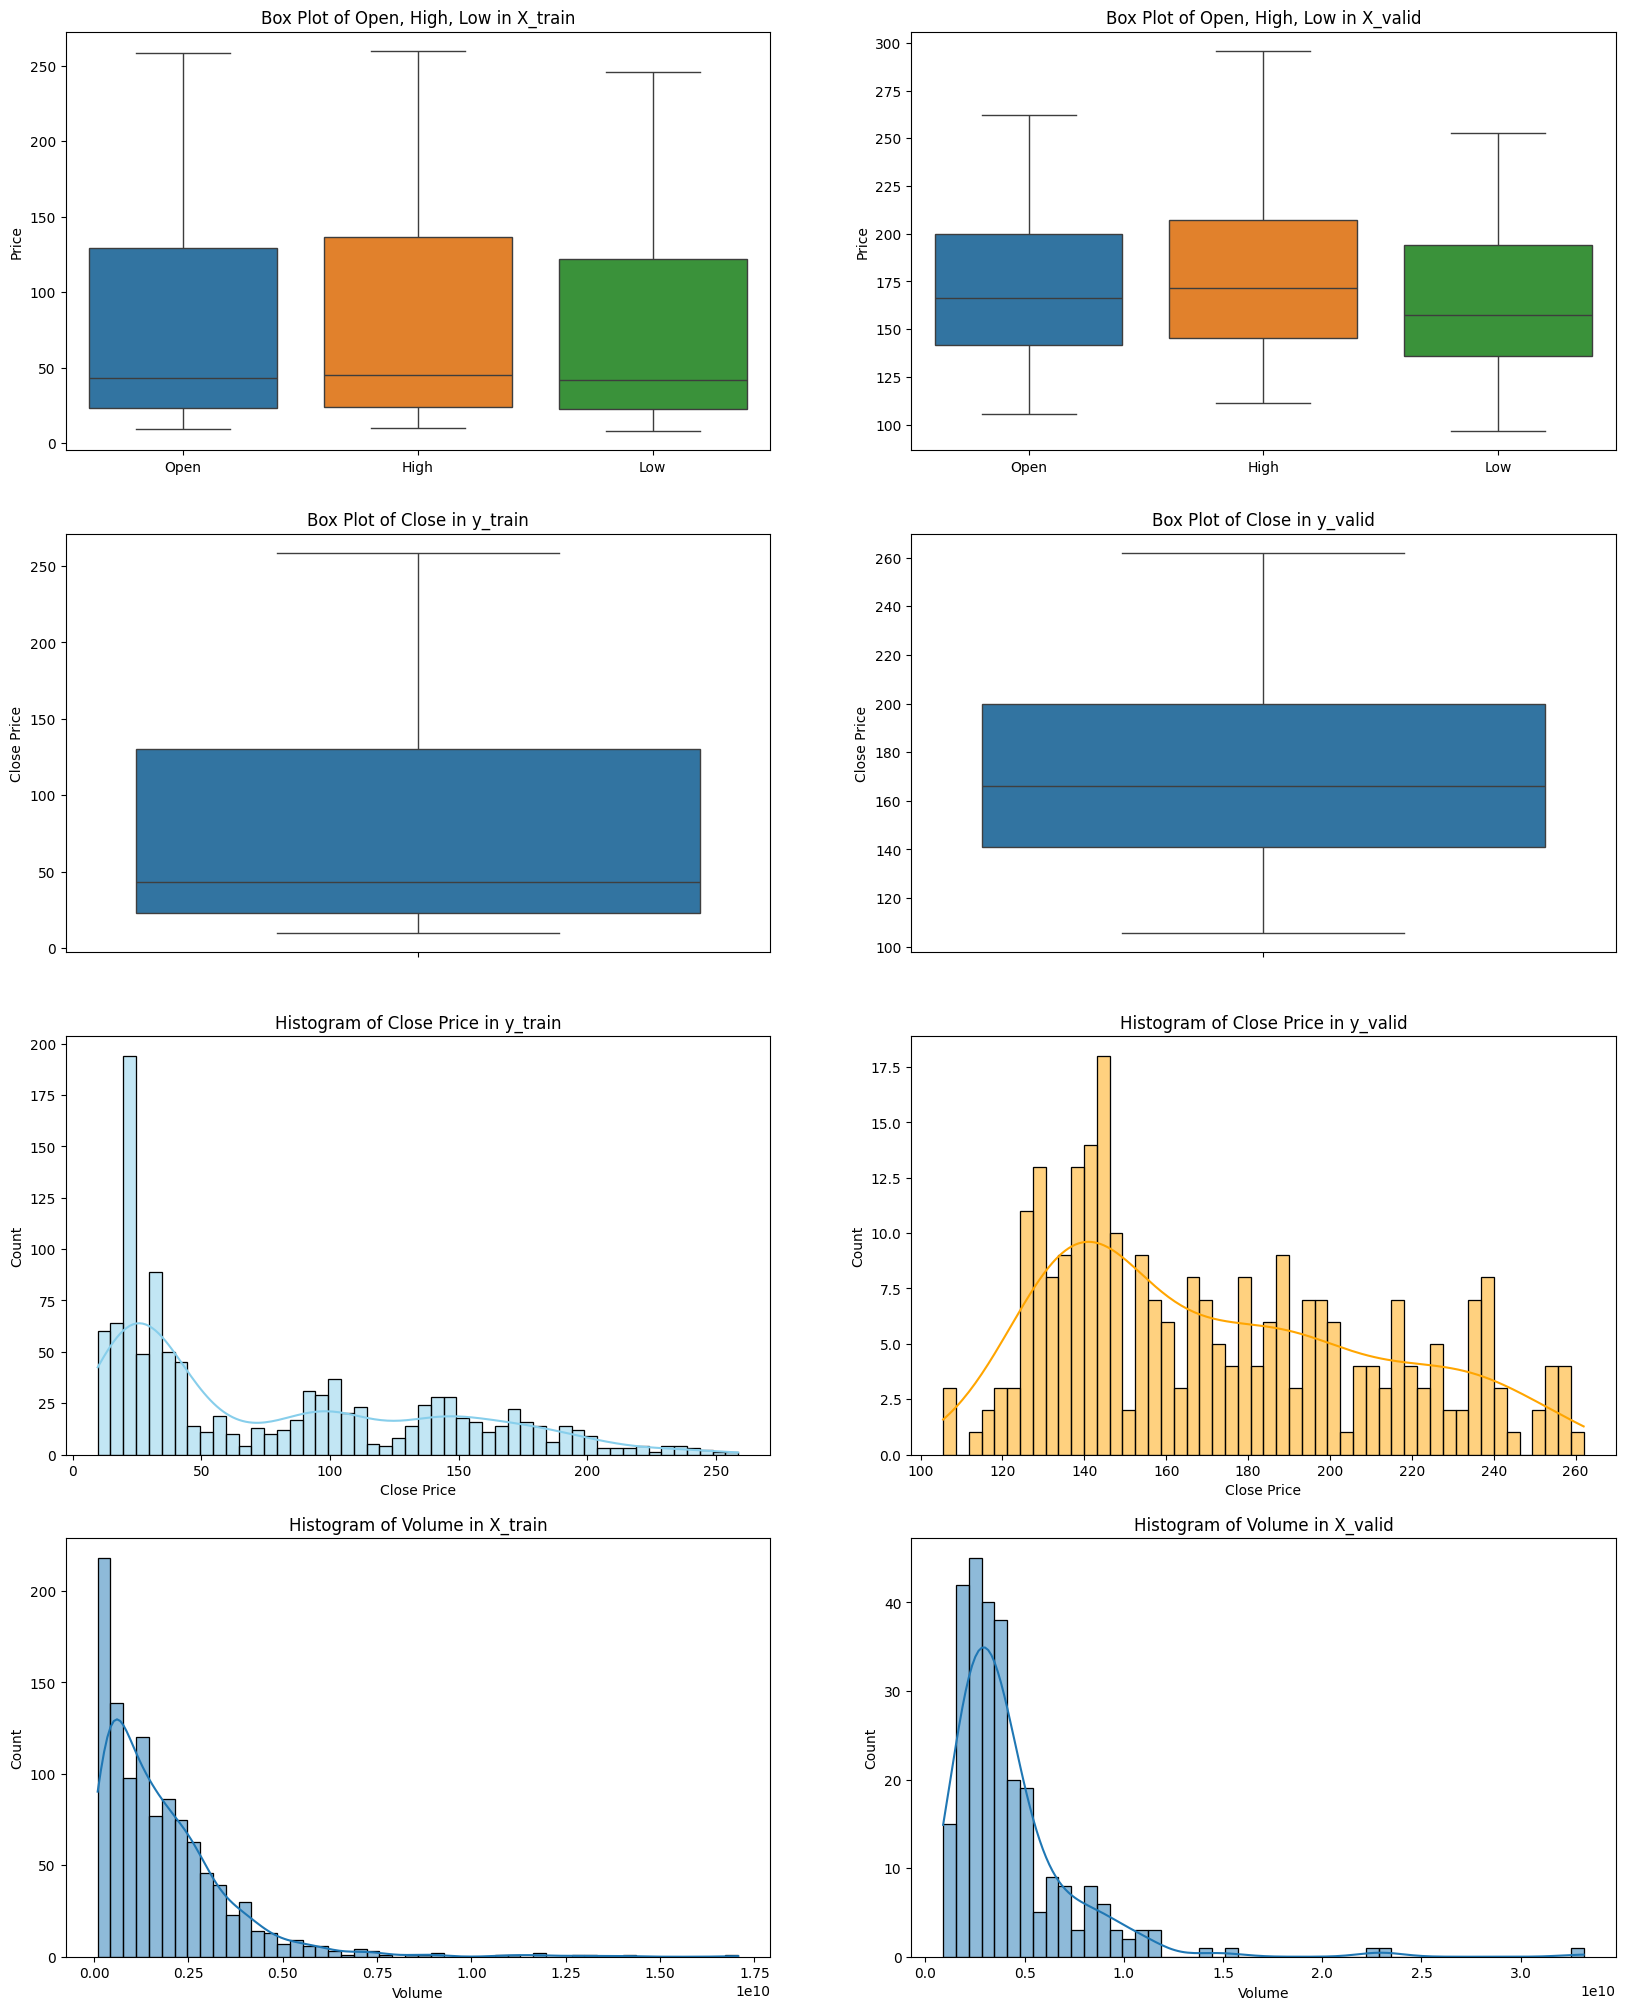

In [ ]:
# 5.1. Visualization-based outlier detection
fig, axes = plt.subplots(4, 2, figsize=(20, 25))

# --- 1. Box plots for X_train[Open, High, Low] ---
sns.boxplot(data=X_train[['Open', 'High', 'Low']], ax=axes[0, 0])
axes[0, 0].set_title('Box Plot of Open, High, Low in X_train')
axes[0, 0].set_ylabel('Price')

# --- 2. Box plots for X_valid[Open, High, Low] ---
sns.boxplot(data=X_valid[['Open', 'High', 'Low']], ax=axes[0, 1])
axes[0, 1].set_title('Box Plot of Open, High, Low in X_valid')
axes[0, 1].set_ylabel('Price')

# --- 3. Box plot for y_train (Close) ---
sns.boxplot(y=y_train, ax=axes[1, 0])
axes[1, 0].set_title('Box Plot of Close in y_train')
axes[1, 0].set_ylabel('Close Price')

# --- 4. Box plot for y_valid (Close) ---
sns.boxplot(y=y_valid, ax=axes[1, 1])
axes[1, 1].set_title('Box Plot of Close in y_valid')
axes[1, 1].set_ylabel('Close Price')

# --- 5. Histogram for y_train (Close) ---
sns.histplot(y_train, kde=True, ax=axes[2, 0], bins=50, color='skyblue')
axes[2, 0].set_title('Histogram of Close Price in y_train')
axes[2, 0].set_xlabel('Close Price')

# --- 6. Histogram for y_valid (Close) ---
sns.histplot(y_valid, kde=True, ax=axes[2, 1], bins=50, color='orange')
axes[2, 1].set_title('Histogram of Close Price in y_valid')
axes[2, 1].set_xlabel('Close Price')

# --- 7. Histogram for Volume in X_train ---
sns.histplot(X_train['Volume'], kde=True, ax=axes[3, 0], bins=50)
axes[3, 0].set_title('Histogram of Volume in X_train')
axes[3, 0].set_xlabel('Volume')

# --- 8. Histogram for Volume in X_valid ---
sns.histplot(X_valid['Volume'], kde=True, ax=axes[3, 1], bins=50)
axes[3, 1].set_title('Histogram of Volume in X_valid')
axes[3, 1].set_xlabel('Volume')

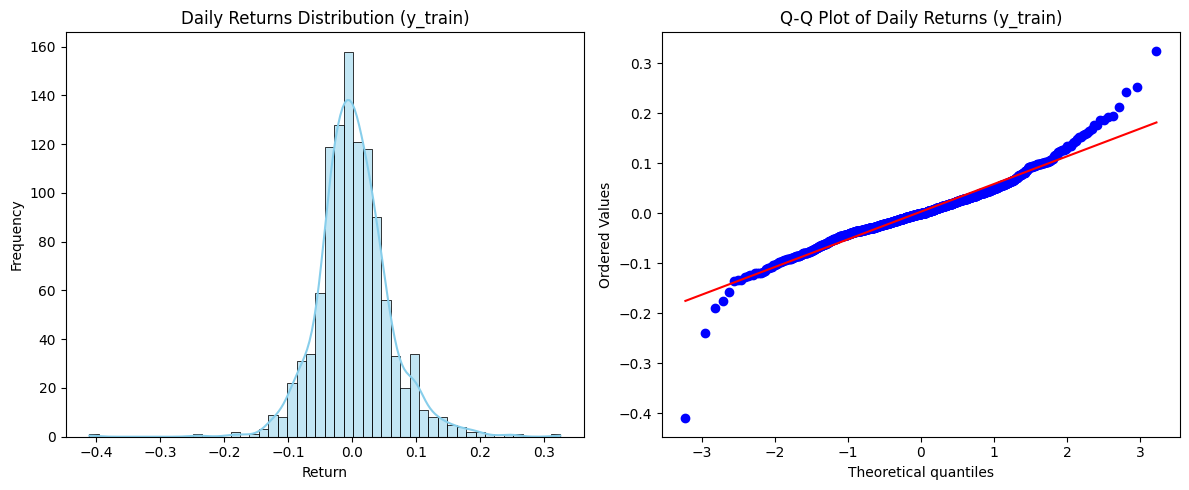

In [ ]:
# Separate figure for validation set
fig, axes = plt.subplots(1, 2, figsize=(12, 5))


# --- Row 3: Distribution & QQ Plot ---

# Histogram of daily returns in y_train
daily_returns_train = y_train.pct_change().dropna()
sns.histplot(daily_returns_train, kde=True, ax=axes[0], bins=50, color='skyblue')
axes[0].set_title('Daily Returns Distribution (y_train)')
axes[0].set_xlabel('Return')
axes[0].set_ylabel('Frequency')

# QQ Plot for daily returns in y_train
stats.probplot(daily_returns_train, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot of Daily Returns (y_train)')

plt.tight_layout()
plt.show()

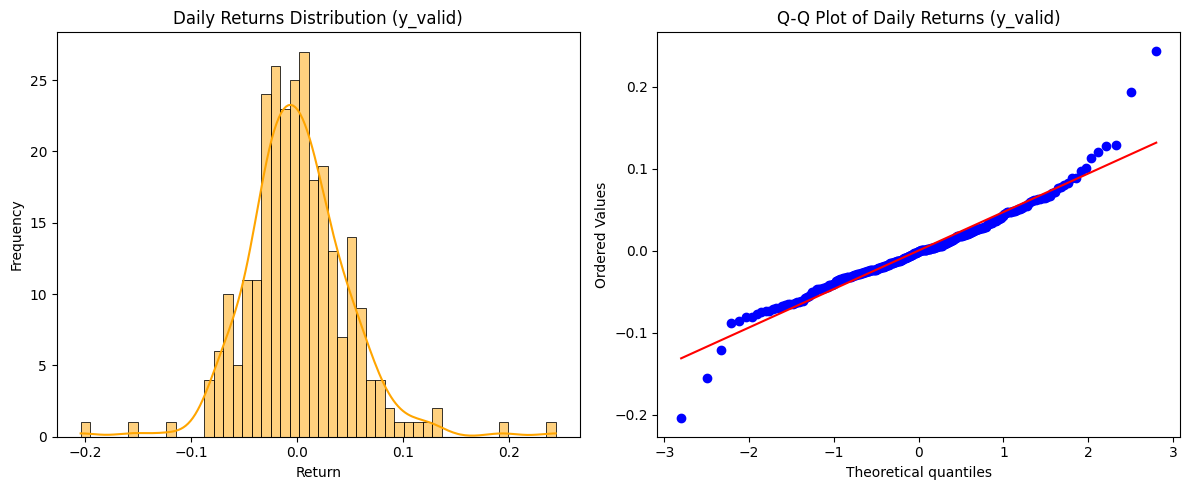

In [ ]:
# Separate figure for validation set
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram of daily returns in y_valid
daily_returns_valid = y_valid.pct_change().dropna()
sns.histplot(daily_returns_valid, kde=True, ax=axes[0], bins=50, color='orange')
axes[0].set_title('Daily Returns Distribution (y_valid)')
axes[0].set_xlabel('Return')
axes[0].set_ylabel('Frequency')

# QQ Plot for daily returns in y_valid
stats.probplot(daily_returns_valid, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot of Daily Returns (y_valid)')

plt.tight_layout()
plt.show()



----- Z-Score Method -----
Z-Score outliers in Open (threshold=3.75): 0
Z-Score outliers in High (threshold=3.75): 0
Z-Score outliers in Low (threshold=3.75): 0
Z-Score outliers in Volume (threshold=3.0): 18
Z-Score outliers in Close (threshold=3.75): 0


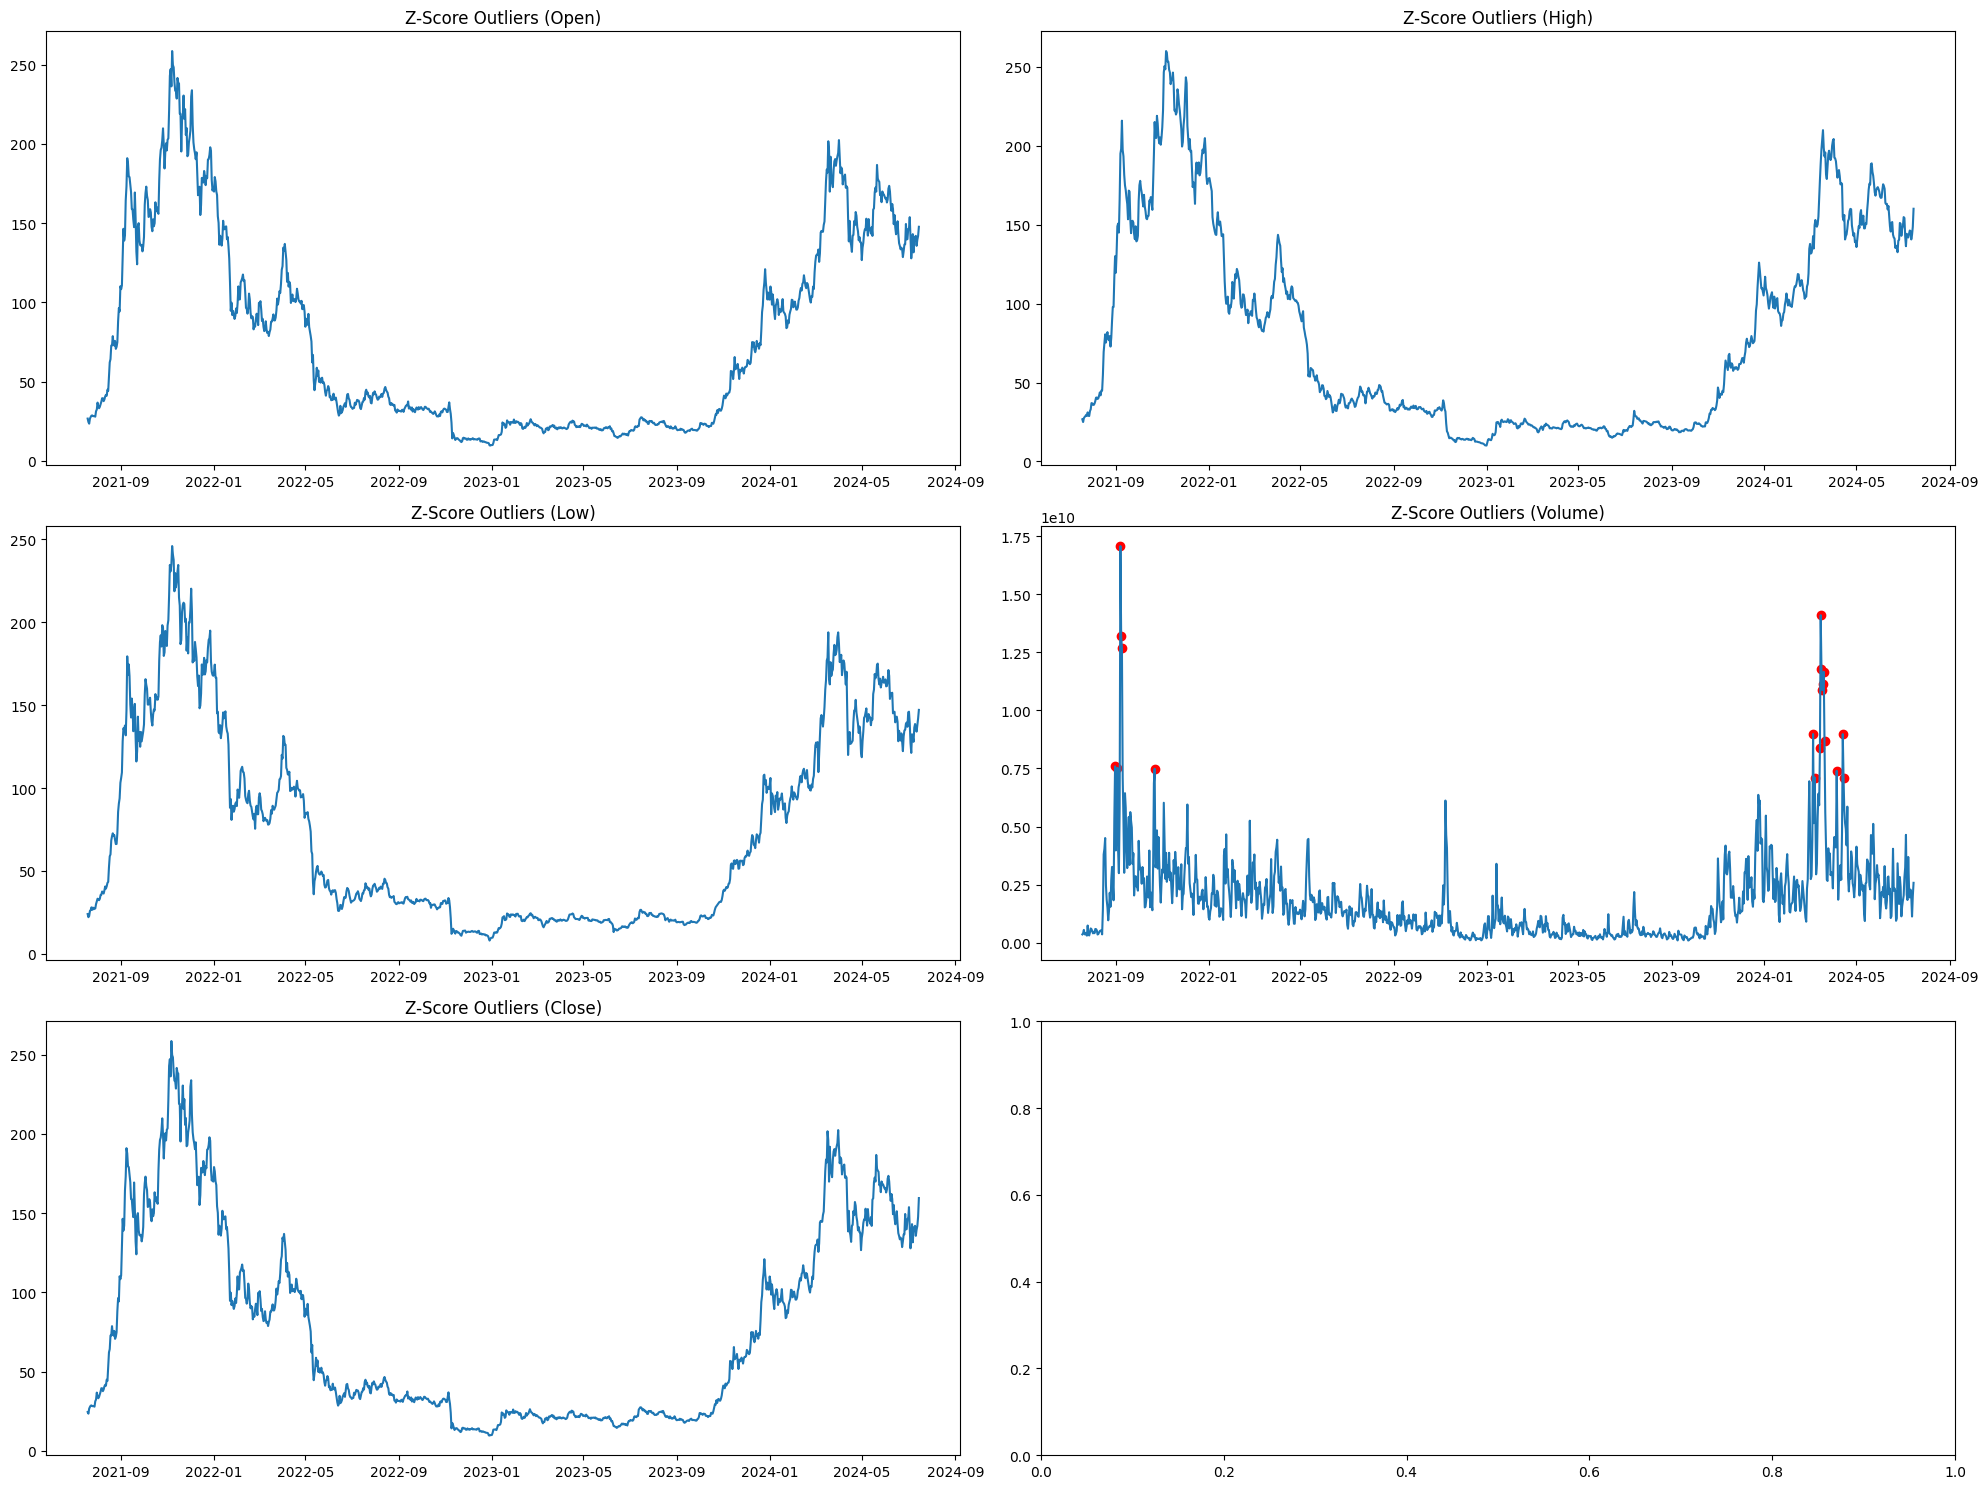

In [ ]:
# # # 5.2.1. Z-Score Method
# print("\n----- Z-Score Method -----")
# z_scores = {}
# for column in ['Open', 'High', 'Low', 'Volume']:
#     z_scores[column] = np.abs(stats.zscore(X_train[column]))

#     # Identify outliers (typically |z| > 4)
#     outliers_others_z = X_train[z_scores[column] > 3]
#     print(f"Z-Score outliers in {column}: {len(outliers_others_z)} ({len(outliers_others_z)/len(df)*100:.2f}%)")

#     if len(outliers_others_z) > 0:
#       print("First few outliers:")
#       print(outliers_others_z.head())
#       print("\n")

# z_scores['Close'] = np.abs(stats.zscore(y_train))
# outliers_close_z = y_train[z_scores['Close'] > 3]
# print(f"Z-Score outliers in Close: {len(outliers_close_z)} ({len(outliers_close_z)/len(y_train)*100:.2f}%)")

# if len(outliers_close_z) > 0:
#     print("First few outliers:")
#     print(outliers_close_z.head())
#     print("\n")


import matplotlib.pyplot as plt

# Define thresholds
PRICE_THRESHOLD = 3.75  # For Open, High, Low, Close
VOLUME_THRESHOLD = 3.0  # For Volume

# ----- Z-Score Method -----
print("\n----- Z-Score Method -----")
z_scores = {}
outliers_z = {}

for column in ['Open', 'High', 'Low', 'Volume']:
    z_scores[column] = np.abs(stats.zscore(X_train[column]))
    threshold = VOLUME_THRESHOLD if column == 'Volume' else PRICE_THRESHOLD
    outliers = X_train[z_scores[column] > threshold]
    outliers_z[column] = outliers
    print(f"Z-Score outliers in {column} (threshold={threshold}): {len(outliers)}")

# Handle Close separately
z_scores['Close'] = np.abs(stats.zscore(y_train))
outliers_close_z = y_train[z_scores['Close'] > PRICE_THRESHOLD]
outliers_z['Close'] = outliers_close_z
print(f"Z-Score outliers in Close (threshold={PRICE_THRESHOLD}): {len(outliers_close_z)}")

# Plot Z-Score Outliers
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
axes = axes.flatten()
for i, col in enumerate(['Open', 'High', 'Low', 'Volume', 'Close']):
    if col == 'Close':
        axes[i].plot(y_train.index, y_train, label=f'{col} Price')
        axes[i].scatter(outliers_z[col].index, outliers_z[col], color='red', label='Outliers')
    else:
        axes[i].plot(X_train.index, X_train[col], label=f'{col}')
        axes[i].scatter(outliers_z[col].index, X_train.loc[outliers_z[col].index, col], color='red')
    axes[i].set_title(f'Z-Score Outliers ({col})')
plt.tight_layout()
plt.show()


----- IQR Method -----
IQR outliers in Open: 0
IQR outliers in High: 0
IQR outliers in Low: 0
IQR outliers in Volume: 36


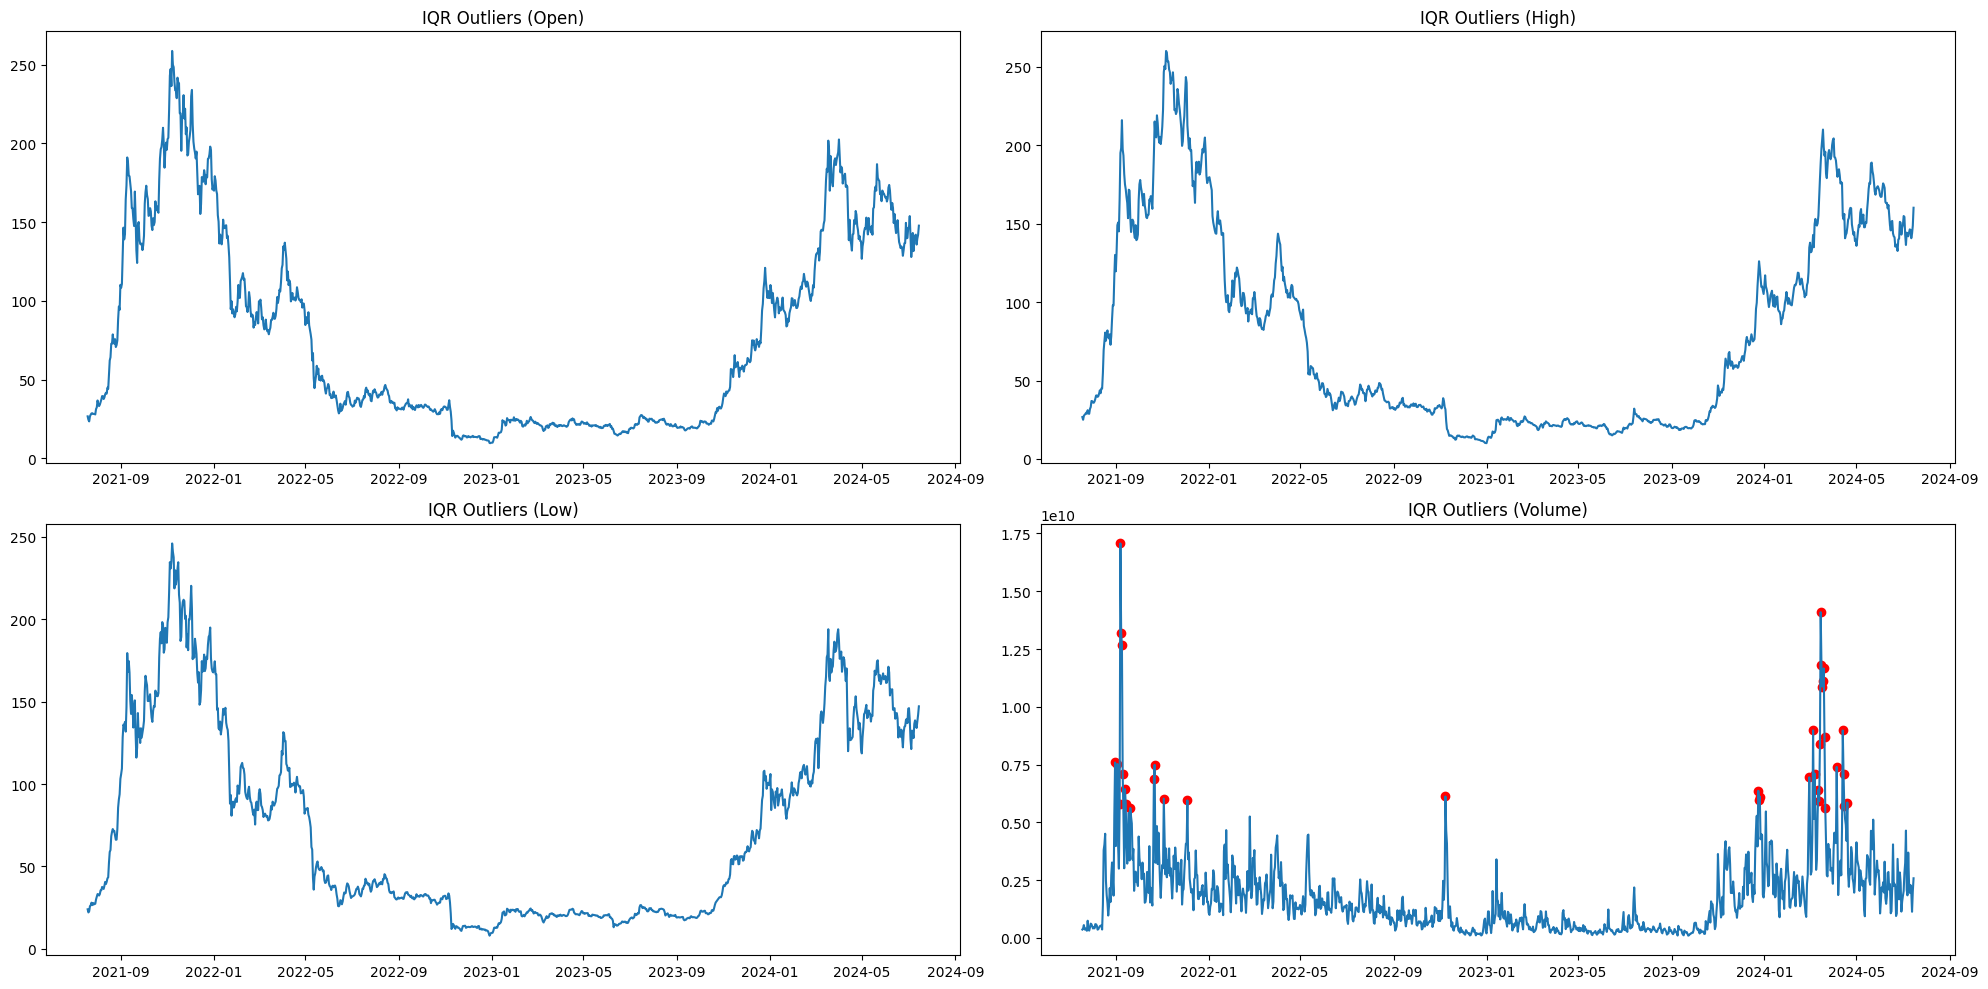

In [ ]:
# # 5.2.2. IQR Method
# print("\n----- IQR Method -----")
# outliers_iqr = pd.DataFrame()

# for column in ['Open', 'High', 'Low', 'Volume']:
#     Q1 = X_train[column].quantile(0.25)
#     Q3 = X_train[column].quantile(0.75)
#     IQR = Q3 - Q1

#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     outliers_others_iqr = X_train[(X_train[column] < lower_bound) | (X_train[column] > upper_bound)]
#     print(f"IQR outliers in {column}: {len(outliers_others_iqr)} ({len(outliers_others_iqr)/len(X_train)*100:.2f}%)")

#     if len(outliers_others_iqr) > 0:
#         print(f"Range for {column}: [{lower_bound:.2f}, {upper_bound:.2f}]")
#         print("First few outliers:")
#         print(outliers_others_iqr.head())
#         print("\n")

#         # Store outliers for potential treatment
#         if outliers_others_iqr.shape[0] > 0:
#             if outliers_iqr.empty:
#                 outliers_iqr = outliers_others_iqr.copy()
#             else:
#                 outliers_iqr = pd.concat([outliers_iqr, outliers_others_iqr])
#                 outliers_iqr = outliers_iqr[~outliers_iqr.index.duplicated(keep='first')]

# # Handle target variable separately
# Q1_close = y_train.quantile(0.25)
# Q3_close = y_train.quantile(0.75)
# IQR_close = Q3_close - Q1_close
# lower_bound_close = Q1_close - 1.5 * IQR_close
# upper_bound_close = Q3_close + 1.5 * IQR_close

# outliers_close_iqr = y_train[(y_train < lower_bound_close) | (y_train > upper_bound_close)]
# print(f"IQR outliers in Close: {len(outliers_close_iqr)} ({len(outliers_close_iqr)/len(y_train)*100:.2f}%)")

# ----- IQR Method (Keep Default 1.5*IQR) -----
print("\n----- IQR Method -----")
outliers_iqr = pd.DataFrame()

for column in ['Open', 'High', 'Low', 'Volume']:
    Q1 = X_train[column].quantile(0.25)
    Q3 = X_train[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = X_train[(X_train[column] < lower) | (X_train[column] > upper)]
    print(f"IQR outliers in {column}: {len(outliers)}")

# Plot IQR Outliers
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()
for i, col in enumerate(['Open', 'High', 'Low', 'Volume']):
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    lower = Q1 - 1.5*(Q3 - Q1)
    upper = Q3 + 1.5*(Q3 - Q1)
    outliers = X_train[(X_train[col] < lower) | (X_train[col] > upper)]
    axes[i].plot(X_train.index, X_train[col], label=col)
    axes[i].scatter(outliers.index, outliers[col], color='red')
    axes[i].set_title(f'IQR Outliers ({col})')
plt.tight_layout()
plt.show()


----- Modified Z-Score Method -----
Modified Z-Score outliers in Open (threshold=3.75): 39
Modified Z-Score outliers in High (threshold=3.75): 37
Modified Z-Score outliers in Low (threshold=3.75): 39
Modified Z-Score outliers in Volume (threshold=3.0): 38
Modified Z-Score outliers in Close (threshold=3.75): 38


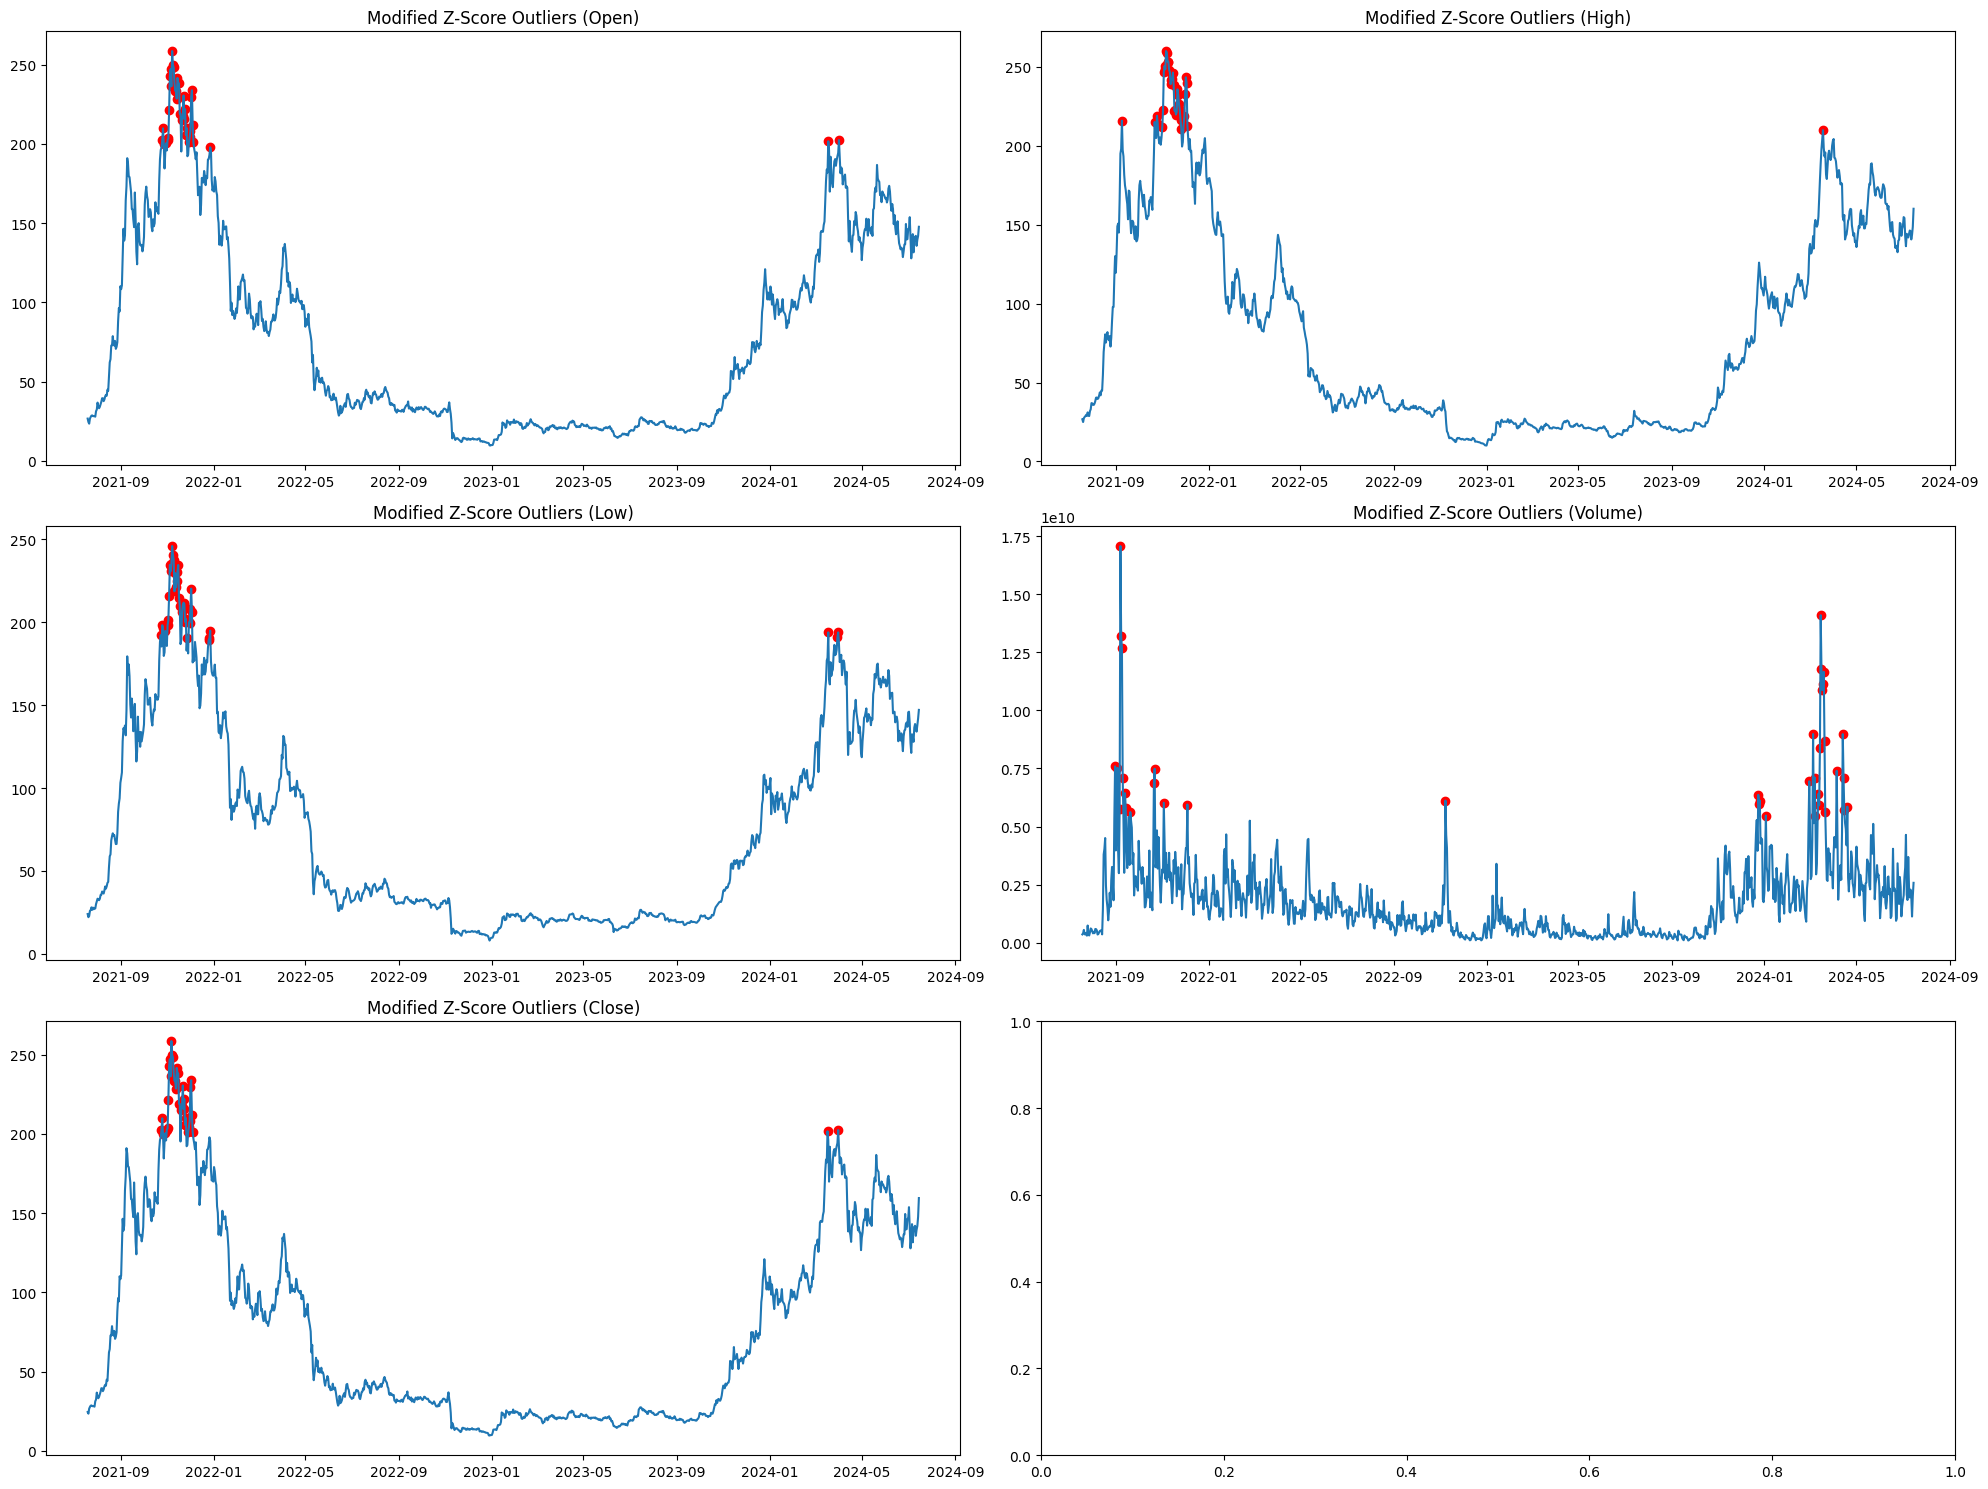

In [ ]:
# # 5.2.3. Modified Z-Score (more robust to outliers)
# print("\n----- Modified Z-Score Method -----")
# for column in ['Open', 'High', 'Low', 'Volume']:
#     # Calculate median and MAD (Median Absolute Deviation)
#     median = X_train[column].median()
#     mad_other = np.median(np.abs(X_train[column] - median))

#     # Calculate modified z-scores
#     if mad_other > 0:  # Avoid division by zero
#         modified_z_scores = 0.6745 * np.abs(X_train[column] - median) / mad_other
#         outliers_others_z_modified = X_train[modified_z_scores > 3.5]  # Threshold commonly used
#         print(f"Modified Z-Score outliers in {column}: {len(outliers_others_z_modified)} ({len(outliers_others_z_modified)/len(X_train)*100:.2f}%)")

#         if len(outliers_others_z_modified) > 0:
#             print("First few outliers:")
#             print(outliers_others_z_modified.head())
#             print("\n")
#     else:
#         print(f"MAD for {column} is zero - cannot compute modified Z-scores")


# median = y_train.median()  # No need to specify 'Close' here
# mad_close = np.median(np.abs(y_train - median))

# if mad_close > 0:  # Avoid division by zero
#         modified_z_scores = 0.6745 * np.abs(y_train - median) / mad_close
#         outliers_close_z_modified = y_train[modified_z_scores > 3.5]  # Threshold commonly used
#         print(f"Modified Z-Score outliers in Close: {len(outliers_close_z_modified)} ({len(outliers_close_z_modified)/len(y_train)*100:.2f}%)")

#         if len(outliers_close_z_modified) > 0:
#             print("First few outliers:")
#             print(outliers_close_z_modified.head())
#             print("\n")


#  ----- Modified Z-Score Method -----
print("\n----- Modified Z-Score Method -----")
outliers_modz = {}

for column in ['Open', 'High', 'Low', 'Volume']:
    median = X_train[column].median()
    mad = np.median(np.abs(X_train[column] - median))
    threshold = VOLUME_THRESHOLD if column == 'Volume' else PRICE_THRESHOLD
    if mad > 0:
        mod_z = 0.6745 * (X_train[column] - median) / mad
        outliers = X_train[np.abs(mod_z) > threshold]
        outliers_modz[column] = outliers
        print(f"Modified Z-Score outliers in {column} (threshold={threshold}): {len(outliers)}")

# Handle Close separately
median_close = y_train.median()
mad_close = np.median(np.abs(y_train - median_close))
if mad_close > 0:
    mod_z_close = 0.6745 * (y_train - median_close) / mad_close
    outliers_close_modz = y_train[np.abs(mod_z_close) > PRICE_THRESHOLD]
    outliers_modz['Close'] = outliers_close_modz
    print(f"Modified Z-Score outliers in Close (threshold={PRICE_THRESHOLD}): {len(outliers_close_modz)}")

# Plot Modified Z-Score Outliers
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
axes = axes.flatten()
for i, col in enumerate(['Open', 'High', 'Low', 'Volume', 'Close']):
    if col == 'Close':
        axes[i].plot(y_train.index, y_train, label='Close Price')
        axes[i].scatter(outliers_modz[col].index, outliers_modz[col], color='red')
    else:
        axes[i].plot(X_train.index, X_train[col], label=col)
        axes[i].scatter(outliers_modz[col].index, X_train.loc[outliers_modz[col].index, col], color='red')
    axes[i].set_title(f'Modified Z-Score Outliers ({col})')
plt.tight_layout()
plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# from scipy import stats

# # 1. Z-Score Method
# print("----- Z-Score Method -----")
# z_scores = {}
# for column in ['Open', 'High', 'Low', 'Volume']:
#     z_scores[column] = np.abs(stats.zscore(X_train[column]))

#     # Identify outliers (typically |z| > 3)
#     outliers = X_train[z_scores[column] > 3]
#     print(f"Z-Score outliers in {column}: {len(outliers)} ({len(outliers)/len(X_train)*100:.2f}%)")

#     if len(outliers) > 0:
#         print("First few outliers:")
#         print(outliers.head())
#         print("\n")

# # Handle target variable separately
# z_scores_close = np.abs(stats.zscore(y_train))
# outliers_close = y_train[z_scores_close > 3]
# print(f"Z-Score outliers in Close: {len(outliers_close)} ({len(outliers_close)/len(y_train)*100:.2f}%)")

# if len(outliers_close) > 0:
#     print("First few outliers:")
#     print(outliers_close.head())
#     print("\n")

# # 2. IQR Method
# print("\n----- IQR Method -----")
# outliers_iqr = pd.DataFrame()

# for column in ['Open', 'High', 'Low', 'Volume']:
#     Q1 = X_train[column].quantile(0.25)
#     Q3 = X_train[column].quantile(0.75)
#     IQR = Q3 - Q1

#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     column_outliers = X_train[(X_train[column] < lower_bound) | (X_train[column] > upper_bound)]
#     print(f"IQR outliers in {column}: {len(column_outliers)} ({len(column_outliers)/len(X_train)*100:.2f}%)")

#     if len(column_outliers) > 0:
#         print(f"Range for {column}: [{lower_bound:.2f}, {upper_bound:.2f}]")
#         print("First few outliers:")
#         print(column_outliers.head())
#         print("\n")

# # Handle target variable separately
# Q1_close = y_train.quantile(0.25)
# Q3_close = y_train.quantile(0.75)
# IQR_close = Q3_close - Q1_close
# lower_bound_close = Q1_close - 1.5 * IQR_close
# upper_bound_close = Q3_close + 1.5 * IQR_close

# outliers_close_iqr = y_train[(y_train < lower_bound_close) | (y_train > upper_bound_close)]
# print(f"IQR outliers in Close: {len(outliers_close_iqr)} ({len(outliers_close_iqr)/len(y_train)*100:.2f}%)")

# if len(outliers_close_iqr) > 0:
#     print(f"Range for Close: [{lower_bound_close:.2f}, {upper_bound_close:.2f}]")
#     print("First few outliers:")
#     print(outliers_close_iqr.head())
#     print("\n")

# # 3. Modified Z-Score with adaptive threshold for crypto data
# print("\n----- Modified Z-Score Method -----")

# # Dictionary to store outliers for each column
# outliers_modified_z = {}
# thresholds = {
#     'Open': 5.0,  # Higher threshold for price columns in crypto
#     'High': 5.0,
#     'Low': 5.0,
#     'Volume': 3.5,  # Standard threshold for volume
#     'Close': 5.0   # Higher threshold for price target
# }

# for column in ['Open', 'High', 'Low', 'Volume']:
#     # Calculate median and MAD (Median Absolute Deviation)
#     median = X_train[column].median()
#     mad = np.median(np.abs(X_train[column] - median))

#     # Calculate modified z-scores
#     if mad > 0:  # Avoid division by zero
#         modified_z_scores = 0.6745 * np.abs(X_train[column] - median) / mad
#         threshold = thresholds[column]
#         outliers_modified_z[column] = X_train[modified_z_scores > threshold]
#         print(f"Modified Z-Score outliers in {column} (threshold={threshold}): {len(outliers_modified_z[column])} ({len(outliers_modified_z[column])/len(X_train)*100:.2f}%)")

#         if len(outliers_modified_z[column]) > 0:
#             print("First few outliers:")
#             print(outliers_modified_z[column].head())
#             print("\n")
#     else:
#         print(f"MAD for {column} is zero - cannot compute modified Z-scores")

# # Handle target variable separately
# median_close = y_train.median()
# mad_close = np.median(np.abs(y_train - median_close))

# if mad_close > 0:  # Avoid division by zero
#     modified_z_scores_close = 0.6745 * np.abs(y_train - median_close) / mad_close
#     threshold_close = thresholds['Close']
#     outliers_close_z_modified = y_train[modified_z_scores_close > threshold_close]
#     print(f"Modified Z-Score outliers in Close (threshold={threshold_close}): {len(outliers_close_z_modified)} ({len(outliers_close_z_modified)/len(y_train)*100:.2f}%)")

#     if len(outliers_close_z_modified) > 0:
#         print("First few outliers:")
#         print(outliers_close_z_modified.head())
#         print("\n")
# else:
#     print("MAD for Close is zero - cannot compute modified Z-scores")

# # Visualize the outliers
# plt.figure(figsize=(15, 8))

# # Plot 1: Original Close Price with outliers from different methods
# plt.subplot(2, 1, 1)
# plt.plot(y_train.index, y_train, label='Close Price', color='blue', alpha=0.7)
# if len(outliers_close) > 0:
#     plt.scatter(outliers_close.index, outliers_close, color='red', label='Z-Score Outliers', alpha=0.7)
# if len(outliers_close_iqr) > 0:
#     plt.scatter(outliers_close_iqr.index, outliers_close_iqr, color='green', label='IQR Outliers', alpha=0.7)
# if len(outliers_close_z_modified) > 0:
#     plt.scatter(outliers_close_z_modified.index, outliers_close_z_modified, color='orange', label='Modified Z-Score Outliers', alpha=0.7)
# plt.title('Close Price with Outliers Detected by Different Methods')
# plt.legend()
# plt.grid(True)

# # Plot 2: Compare methods with percentages
# methods = ['Z-Score', 'IQR', 'Modified Z-Score']
# percentages = [
#     len(outliers_close)/len(y_train)*100,
#     len(outliers_close_iqr)/len(y_train)*100,
#     len(outliers_close_z_modified)/len(y_train)*100
# ]

# plt.subplot(2, 1, 2)
# plt.bar(methods, percentages, color=['red', 'green', 'orange'])
# plt.title('Percentage of Outliers Detected in Close Price')
# plt.ylabel('Percentage (%)')
# plt.grid(axis='y')

# plt.tight_layout()
# plt.show()

# # Select the best method based on visualization and percentages
# # Generally for crypto, use the method that gives reasonable outlier percentages (1-5%)
# selected_method = methods[np.argmin([abs(p - 2.5) for p in percentages])]  # Aim for closest to 2.5%
# print(f"\nBased on analysis, the recommended outlier detection method is: {selected_method}")

# # Apply treatment (capping) based on the selected method
# print("\n----- Applying Outlier Treatment -----")
# if selected_method == 'Z-Score':
#     # Apply capping based on Z-Score thresholds
#     for column in ['Open', 'High', 'Low', 'Volume']:
#         mean = X_train[column].mean()
#         std = X_train[column].std()
#         lower_bound = mean - 3 * std
#         upper_bound = mean + 3 * std

#         # Apply to training data
#         X_train[column] = X_train[column].clip(lower=lower_bound, upper=upper_bound)
#         # Apply to validation data
#         X_valid[column] = X_valid[column].clip(lower=lower_bound, upper=upper_bound)

#         print(f"Z-Score capping applied to {column}: [{lower_bound:.2f}, {upper_bound:.2f}]")

#     # Apply to target variable
#     mean_close = y_train.mean()
#     std_close = y_train.std()
#     lower_bound_close = mean_close - 3 * std_close
#     upper_bound_close = mean_close + 3 * std_close

#     y_train = y_train.clip(lower=lower_bound_close, upper=upper_bound_close)
#     y_valid = y_valid.clip(lower=lower_bound_close, upper=upper_bound_close)
#     print(f"Z-Score capping applied to Close: [{lower_bound_close:.2f}, {upper_bound_close:.2f}]")

# elif selected_method == 'IQR':
#     # Apply capping based on IQR thresholds
#     for column in ['Open', 'High', 'Low', 'Volume']:
#         Q1 = X_train[column].quantile(0.25)
#         Q3 = X_train[column].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR

#         # Apply to training data
#         X_train[column] = X_train[column].clip(lower=lower_bound, upper=upper_bound)
#         # Apply to validation data
#         X_valid[column] = X_valid[column].clip(lower=lower_bound, upper=upper_bound)

#         print(f"IQR capping applied to {column}: [{lower_bound:.2f}, {upper_bound:.2f}]")

#     # Apply to target variable
#     Q1_close = y_train.quantile(0.25)
#     Q3_close = y_train.quantile(0.75)
#     IQR_close = Q3_close - Q1_close
#     lower_bound_close = Q1_close - 1.5 * IQR_close
#     upper_bound_close = Q3_close + 1.5 * IQR_close

#     y_train = y_train.clip(lower=lower_bound_close, upper=upper_bound_close)
#     y_valid = y_valid.clip(lower=lower_bound_close, upper=upper_bound_close)
#     print(f"IQR capping applied to Close: [{lower_bound_close:.2f}, {upper_bound_close:.2f}]")

# else:  # Modified Z-Score
#     # Apply capping based on Modified Z-Score thresholds
#     for column in ['Open', 'High', 'Low', 'Volume']:
#         median = X_train[column].median()
#         mad = np.median(np.abs(X_train[column] - median))
#         threshold = thresholds[column]

#         if mad > 0:
#             lower_bound = median - (threshold * mad / 0.6745)
#             upper_bound = median + (threshold * mad / 0.6745)

#             # Apply to training data
#             X_train[column] = X_train[column].clip(lower=lower_bound, upper=upper_bound)
#             # Apply to validation data
#             X_valid[column] = X_valid[column].clip(lower=lower_bound, upper=upper_bound)

#             print(f"Modified Z-Score capping applied to {column}: [{lower_bound:.2f}, {upper_bound:.2f}]")

#     # Apply to target variable
#     median_close = y_train.median()
#     mad_close = np.median(np.abs(y_train - median_close))
#     threshold_close = thresholds['Close']

#     if mad_close > 0:
#         lower_bound_close = median_close - (threshold_close * mad_close / 0.6745)
#         upper_bound_close = median_close + (threshold_close * mad_close / 0.6745)

#         y_train = y_train.clip(lower=lower_bound_close, upper=upper_bound_close)
#         y_valid = y_valid.clip(lower=lower_bound_close, upper=upper_bound_close)
#         print(f"Modified Z-Score capping applied to Close: [{lower_bound_close:.2f}, {upper_bound_close:.2f}]")

# print("\nOutlier treatment complete.")

In [ ]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(12, 6))
# plt.plot(y_train.index, y_train)
# plt.scatter(outliers_close_z_modified.index, outliers_close_z_modified, color='red', alpha=0.5)
# plt.title('Close Price with Modified Z-Score Outliers')
# plt.show()

In [ ]:
# # 5.2. Statistical-based outlier detection

# # 5.2.1. Z-Score Method
# print("\n----- Z-Score Method -----")
# # Calculate z-scores for price and volume
# z_scores = {}
# for column in ['Open', 'High', 'Low', 'Volume']:
#     z_scores[column] = np.abs(stats.zscore(X_train[column]))

#     # Identify outliers (typically |z| > 3)
#     outliers_others = X_train[z_scores[column] > 3]
#     print(f"Z-Score outliers in {column}: {len(outliers_others)} ({len(outliers_others)/len(df)*100:.2f}%)")

# z_scores['Close'] = np.abs(stats.zscore(y_train))
# outliers_close = y_train[z_scores['Close'] > 3]
# print(f"Z-Score outliers in Close: {len(outliers_close)} ({len(outliers_close)/len(y_train)*100:.2f}%)")

#     # if len(outliers) > 0:
#     #     print("First few outliers:")
#     #     print(outliers.head())
#     #     print("\n")

# 5.2.2. IQR Method
# print("\n----- IQR Method -----")
# outliers_iqr = pd.DataFrame()

# for column in ['Open', 'High', 'Low', 'Close', 'Volume']:
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1

#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     column_outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
#     print(f"IQR outliers in {column}: {len(column_outliers)} ({len(column_outliers)/len(df)*100:.2f}%)")

#     if len(column_outliers) > 0:
#         print(f"Range for {column}: [{lower_bound:.2f}, {upper_bound:.2f}]")
#         print("First few outliers:")
#         print(column_outliers.head())
#         print("\n")

#         # Store outliers for potential treatment
#         if column_outliers.shape[0] > 0:
#             if outliers_iqr.empty:
#                 outliers_iqr = column_outliers.copy()
#             else:
#                 outliers_iqr = pd.concat([outliers_iqr, column_outliers])
#                 outliers_iqr = outliers_iqr[~outliers_iqr.index.duplicated(keep='first')]

# 5.2.3. Modified Z-Score (more robust to outliers)
# print("\n----- Modified Z-Score Method -----")
# for column in ['Open', 'High', 'Low', 'Close', 'Volume']:
#     # Calculate median and MAD (Median Absolute Deviation)
#     median = df[column].median()
#     mad = np.median(np.abs(df[column] - median))

#     # Calculate modified z-scores
#     if mad > 0:  # Avoid division by zero
#         modified_z_scores = 0.6745 * np.abs(df[column] - median) / mad
#         outliers = df[modified_z_scores > 3.5]  # Threshold commonly used
#         print(f"Modified Z-Score outliers in {column}: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

#         if len(outliers) > 0:
#             print("First few outliers:")
#             print(outliers.head())
#             print("\n")
#     else:
#         print(f"MAD for {column} is zero - cannot compute modified Z-scores")

In [ ]:
# # 5.3. Domain-specific outlier detection for cryptocurrencies
# print("\n----- Domain-Specific Methods -----")

# # 5.3.1. Extreme price jumps (daily returns)
# print("\n----- Extreme Price Jumps -----")
# daily_returns = y_train.pct_change()
# extreme_returns = y_train[np.abs(daily_returns) > 0.20]  # 20% daily move is often considered extreme
# print(f"Days with >20% price movement: {len(extreme_returns)} ({len(extreme_returns)/len(y_train)*100:.2f}%)")
# if len(extreme_returns) > 0:
#     print("First few extreme movements:")
#     print(extreme_returns.head())

# # 5.3.2. Trading volume spikes
# print("\n----- Volume Spikes -----")
# # Calculate rolling average volume (20-day)
# X_train['Rolling_Volume_20d'] = X_train['Volume'].rolling(window=20).mean()

# # Find days where volume exceeded 3x the rolling average
# volume_spikes = X_train[X_train['Volume'] > 3 * X_train['Rolling_Volume_20d']].dropna()
# print(f"Volume spike days: {len(volume_spikes)} ({len(volume_spikes)/len(X_train.dropna())*100:.2f}%)")
# if len(volume_spikes) > 0:
#     print("First few volume spikes:")
#     print(volume_spikes[['Volume', 'Rolling_Volume_20d']].head())

In [ ]:

# # 5.3.2. Extreme price jumps (daily returns)
# print("\n----- Extreme Price Jumps -----")
# daily_returns = y_valid.pct_change()
# extreme_returns = y_valid[np.abs(daily_returns) > 0.20]  # 20% daily move is often considered extreme
# print(f"Days with >20% price movement: {len(extreme_returns)} ({len(extreme_returns)/len(y_valid)*100:.2f}%)")
# if len(extreme_returns) > 0:
#     print("First few extreme movements:")
#     print(extreme_returns.head())

# # 5.3.2. Trading volume spikes
# print("\n----- Volume Spikes -----")
# # Calculate rolling average volume (20-day)
# X_valid['Rolling_Volume_20d'] = X_valid['Volume'].rolling(window=20).mean()

# # Find days where volume exceeded 3x the rolling average
# volume_spikes = X_valid[X_valid['Volume'] > 3 * X_valid['Rolling_Volume_20d']].dropna()
# print(f"Volume spike days: {len(volume_spikes)} ({len(volume_spikes)/len(X_valid.dropna())*100:.2f}%)")
# if len(volume_spikes) > 0:
#     print("First few volume spikes:")
#     print(volume_spikes[['Volume', 'Rolling_Volume_20d']].head())

In [ ]:
# 5.4. Outlier Treatment

# Create a copy of the original data for treatment demonstrations
df_treated = X_train.copy()
df_treated_c = y_train.copy()



=== Outlier Treatment: MAD-Based Capping ===

----- Capping (MAD) for Open -----
Threshold: 3.75 | Outliers capped: 39
Bounds: [-111.02, 197.88]

Sample capped values:
                     Date  Original     Capped
2021-12-03 00:00:00+00:00    233.89 197.877739
2021-12-27 00:00:00+00:00    197.89 197.877739
2021-11-01 00:00:00+00:00    202.66 197.877739

----- Capping (MAD) for High -----
Threshold: 3.75 | Outliers capped: 37
Bounds: [-117.92, 208.98]

Sample capped values:
                     Date  Original     Capped
2021-11-14 00:00:00+00:00    241.94 208.984411
2021-11-10 00:00:00+00:00    248.09 208.984411
2021-11-01 00:00:00+00:00    211.66 208.984411

----- Capping (MAD) for Low -----
Threshold: 3.75 | Outliers capped: 39
Bounds: [-105.81, 189.19]

Sample capped values:
                     Date  Original     Capped
2021-12-25 00:00:00+00:00    189.33 189.188147
2024-03-18 00:00:00+00:00    193.87 189.188147
2021-11-01 00:00:00+00:00    198.05 189.188147

----- Capping (MAD) f

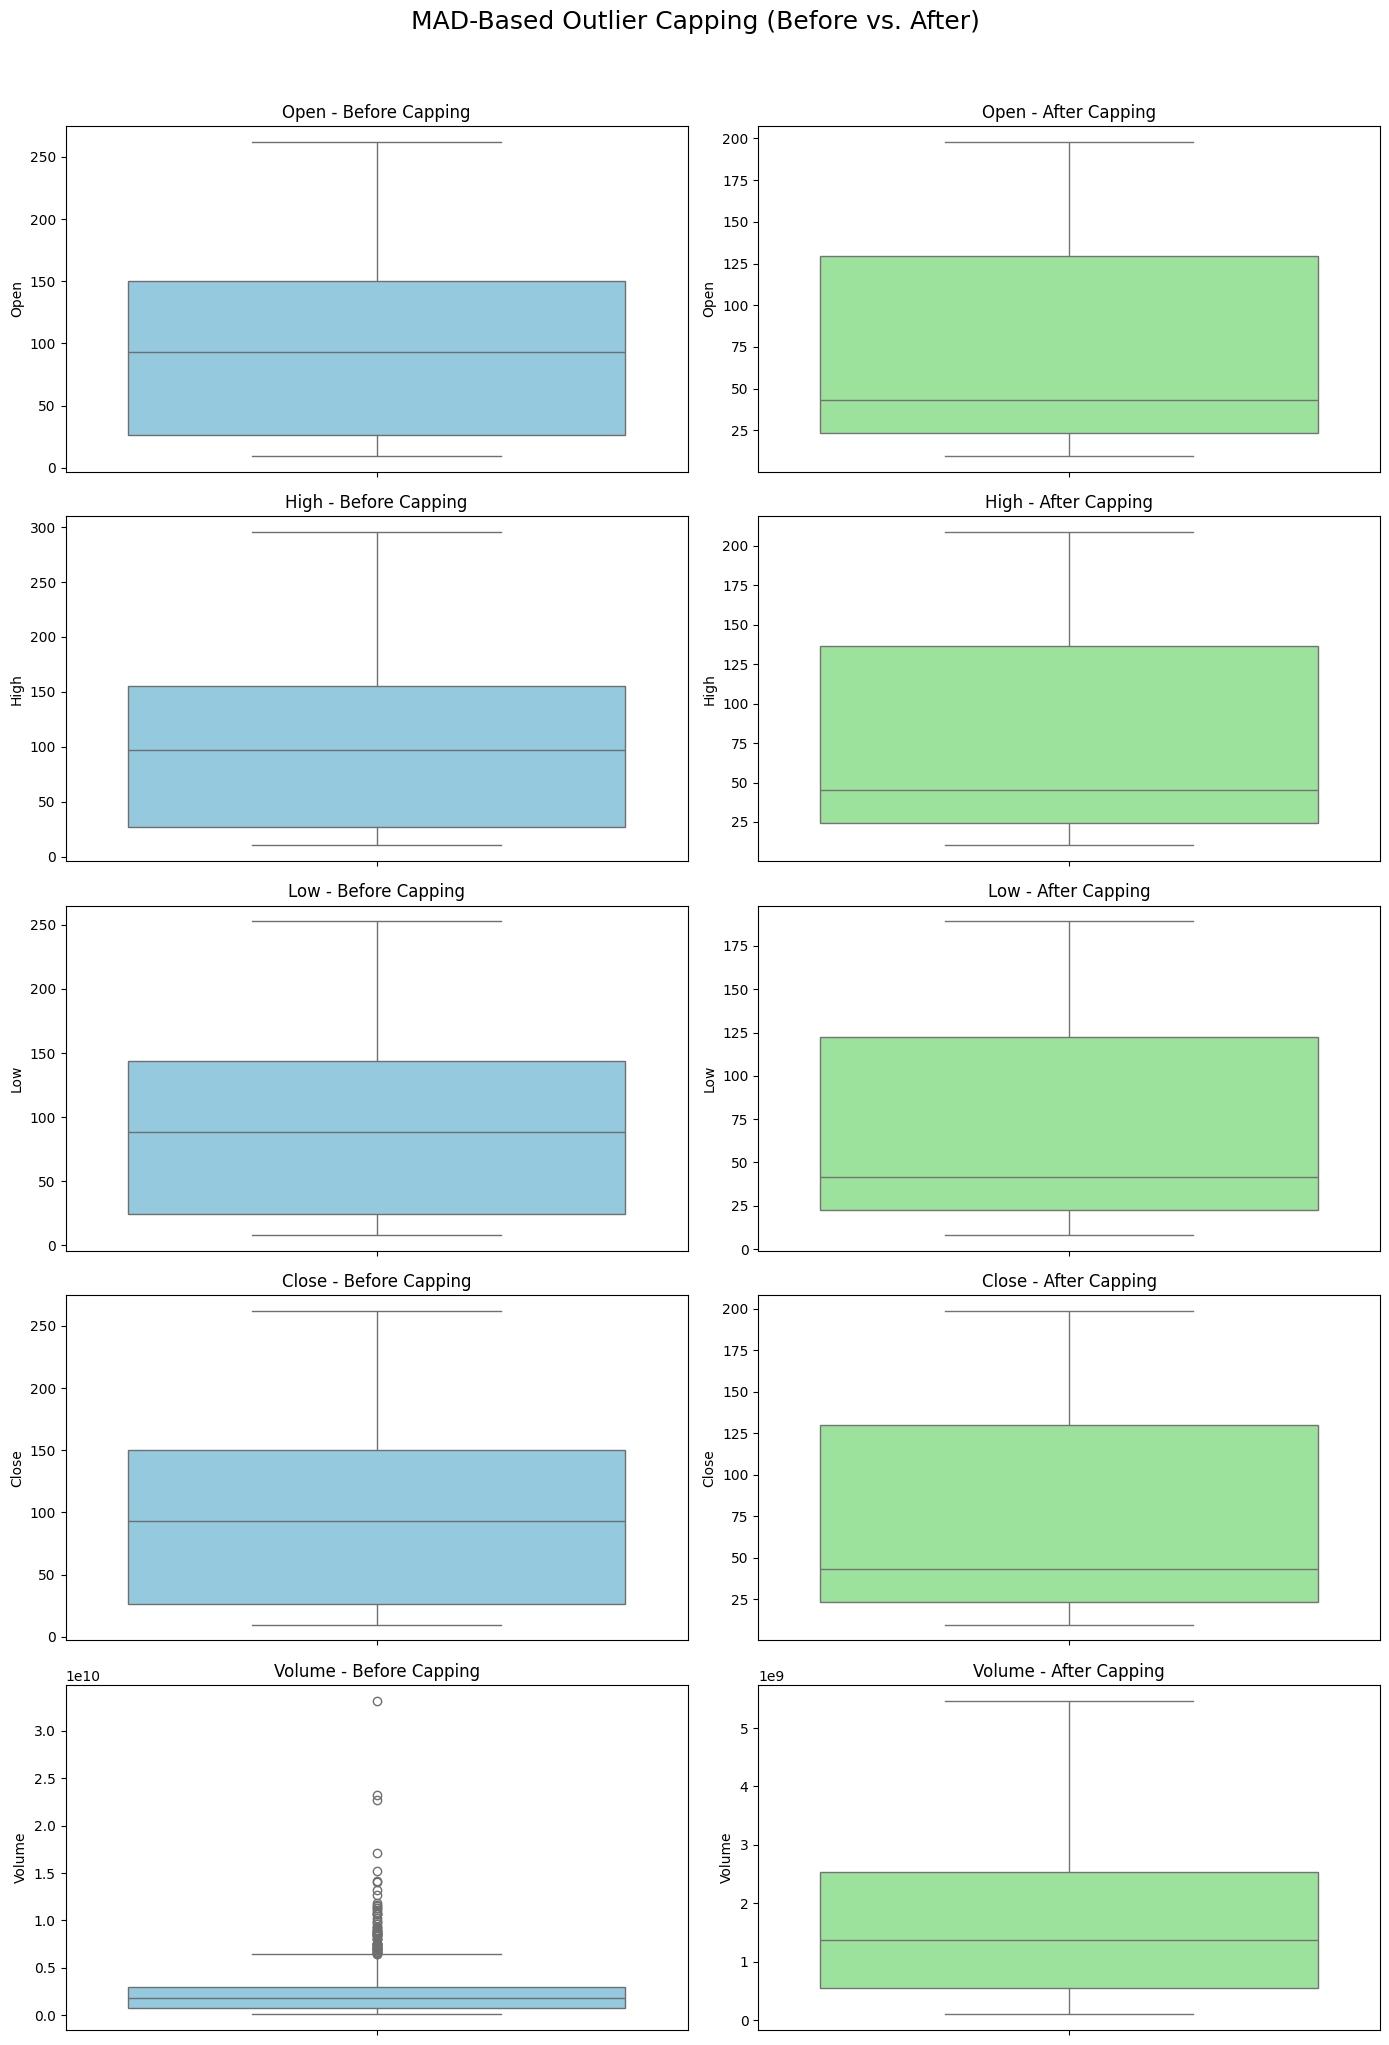

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Define thresholds from detection phase
PRICE_THRESHOLD = 3.75  # For Open, High, Low, Close
VOLUME_THRESHOLD = 3.0  # For Volume

# ----------------------------------------------------------
# 1. Capping (MAD-Based Winsorization) - Best for Crypto
# ----------------------------------------------------------
def mad_based_capping(df_treated, column, threshold):
    """Cap outliers using median and MAD instead of percentiles."""
    median = df_treated[column].median()
    mad = np.median(np.abs(df_treated[column] - median))
    if mad == 0:
        return df_treated[column]  # Avoid division by zero

    # Calculate bounds using modified Z-score formula
    upper_bound = median + (threshold * mad) / 0.6745
    lower_bound = median - (threshold * mad) / 0.6745

    # Identify and cap outliers
    original = df_treated[column].copy()
    capped = original.clip(lower=lower_bound, upper=upper_bound)


    # Track changes
    n_outliers = (original != capped).sum()
    if n_outliers > 0:
        print(f"\n----- Capping (MAD) for {column} -----")
        print(f"Threshold: {threshold} | Outliers capped: {n_outliers}")
        print(f"Bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")

        # Show sample changes
        # sample_idx = original[(original < lower_bound) | (original > upper_bound)].sample(3, random_state=42).index
        # print("\nSample changes:")
        # print(pd.DataFrame({
        #     'Original': original.loc[sample_idx],
        #     'Capped': capped.loc[sample_idx]
        # }))

        # Get sample changes with timestamps
        outlier_mask = (original < lower_bound) | (original > upper_bound)
        sample_outliers = original[outlier_mask].sample(min(3, n_outliers), random_state=42)

        print("\nSample capped values:")
        print(pd.DataFrame({
            'Date': sample_outliers.index,
            'Original': sample_outliers.values,
            'Capped': capped.loc[sample_outliers.index]
        }).to_string(index=False))


    return capped

# Apply to all columns
print("\n=== Outlier Treatment: MAD-Based Capping ===")
for col in ['Open', 'High', 'Low']:
    df_treated[col] = mad_based_capping(df_treated, col, PRICE_THRESHOLD)
df_treated['Volume'] = mad_based_capping(df_treated, 'Volume', VOLUME_THRESHOLD)

def mad_based_capping_close(df_treated_c, threshold):
    """Cap outliers using median and MAD instead of percentiles for Close."""
    median = df_treated_c.median()
    mad = np.median(np.abs(df_treated_c - median))
    if mad == 0:
        return df_treated_c  # Avoid division by zero

    upper_bound = median + (threshold * mad) / 0.6745
    lower_bound = median - (threshold * mad) / 0.6745

    original = df_treated_c.copy()
    capped = original.clip(lower=lower_bound, upper=upper_bound)

    n_outliers = (original != capped).sum()
    if n_outliers > 0:
        print(f"\n----- Capping (MAD) for Close -----")
        print(f"Threshold: {threshold} | Outliers capped: {n_outliers}")
        print(f"Bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")

        # sample_idx = original[(original < lower_bound) | (original > upper_bound)].sample(3, random_state=42).index
        # print("\nSample changes:")
        # print(pd.DataFrame({
        #     'Original': original.loc[sample_idx],
        #     'Capped': capped.loc[sample_idx]
        # }))

        outlier_mask = (original < lower_bound) | (original > upper_bound)
        sample_outliers = original[outlier_mask].sample(min(3, n_outliers), random_state=42)

        print("\nSample capped values:")
        print(pd.DataFrame({
            'Date': sample_outliers.index,
            'Original': sample_outliers.values,
            'Capped': capped.loc[sample_outliers.index]
        }).to_string(index=False))

    return capped

df_treated_c = mad_based_capping_close(df_treated_c, PRICE_THRESHOLD)


import matplotlib.pyplot as plt
import seaborn as sns

# List of columns to visualize
features_to_plot = ['Open', 'High', 'Low', 'Close', 'Volume']

# Create subplots
fig, axes = plt.subplots(nrows=len(features_to_plot), ncols=2, figsize=(14, 4 * len(features_to_plot)))
fig.suptitle("MAD-Based Outlier Capping (Before vs. After)", fontsize=18, y=1.02)

for i, col in enumerate(features_to_plot):
    # Original data
    sns.boxplot(data=df[col], ax=axes[i, 0], color="skyblue")
    axes[i, 0].set_title(f"{col} - Before Capping")

    # Treated data
    treated_data = df_treated[col] if col != 'Close' else df_treated_c
    sns.boxplot(data=treated_data, ax=axes[i, 1], color="lightgreen")
    axes[i, 1].set_title(f"{col} - After Capping")

plt.tight_layout()
plt.show()



In [ ]:

# import matplotlib.pyplot as plt
# import seaborn as sns

# # List of columns to visualize
# features_to_plot = ['Open', 'High', 'Low', 'Close', 'Volume']

# # Create subplots
# fig, axes = plt.subplots(nrows=len(features_to_plot), ncols=2, figsize=(14, 4 * len(features_to_plot)))
# fig.suptitle("MAD-Based Outlier Capping (Before vs. After)", fontsize=18, y=1.02)

# for i, col in enumerate(features_to_plot):
#     # Original data
#     sns.boxplot(data=df[col], ax=axes[i, 0], color="skyblue")
#     axes[i, 0].set_title(f"{col} - Before Capping")

#     # Treated data
#     treated_data = df_treated[col] if col != 'Close' else df_treated_c
#     sns.boxplot(data=treated_data, ax=axes[i, 1], color="lightgreen")
#     axes[i, 1].set_title(f"{col} - After Capping")

# plt.tight_layout()
# plt.show()

In [ ]:
# # Create another copy for smoothing demonstration
# df_smoothed = X_train.copy()
# df_smoothed_c = y_train.copy()

In [ ]:


# # Apply rolling average smoothing for Open, High, Low, Volume
# for window in [3, 7, 14]:
#     for column in ['Open', 'High', 'Low', 'Volume']:
#         df_smoothed[f'{column}_SMA{window}'] = df_smoothed[column].rolling(window=window, center=False).mean()

# # Ensure df_smoothed_c is a DataFrame to hold new columns
# df_smoothed_c = pd.DataFrame(df_smoothed_c)

# # Apply rolling average smoothing for Close separately
# for window in [3, 7, 14]:
#     df_smoothed_c[f'Close_SMA{window}'] = df_smoothed_c['Close'].rolling(window=window, center=False).mean()


# # === Smoothing example for extreme return days ===
# if len(extreme_returns) > 0:
#     sample_dates = extreme_returns.head().index

#     print("Smoothing example for extreme price movement days (Close):")
#     smoothing_comparison = pd.DataFrame({
#         'Original_Close': df_smoothed_c.loc[sample_dates, 'Close'],
#         'SMA3': df_smoothed_c.loc[sample_dates, 'Close_SMA3'],
#         'SMA7': df_smoothed_c.loc[sample_dates, 'Close_SMA7'],
#         'SMA14': df_smoothed_c.loc[sample_dates, 'Close_SMA14'],
#     })
#     print(smoothing_comparison)

#     # # === Plot: Close Price Original vs Smoothed ===
#     # plt.figure(figsize=(14, 7))
#     # plt.plot(df_smoothed_c.index[-100:], df_smoothed_c['Close'][-100:], label='Original Close', alpha=0.7)
#     # plt.plot(df_smoothed_c.index[-100:], df_smoothed_c['Close_SMA7'][-100:], label='7-day SMA', color='orange')
#     # plt.title('Original vs Smoothed Close Price (Last 100 Days)')
#     # plt.xlabel('Date')
#     # plt.ylabel('Price')
#     # plt.grid(True)
#     # plt.legend()
#     # plt.tight_layout()
#     # plt.show()


In [ ]:
# # 5.4.3. Isolation Forest for Anomaly Detection
# print("\n----- Outlier Treatment: Isolation Forest -----")
# from sklearn.ensemble import IsolationForest

# # Select features for anomaly detection
# features = X_train[['Open', 'High', 'Low', 'Volume']].copy()
# features_c = y_train.copy()

# # Fit the model
# isolation_forest = IsolationForest(contamination=0.05, random_state=42)
# anomalies = isolation_forest.fit_predict(features)

# anomalies_c = isolation_forest.fit_predict(features_c)

# # Identify the anomalies (outliers are represented by -1)
# anomaly_indices = np.where(anomalies == -1)[0]
# print(f"Isolation Forest detected {len(anomaly_indices)} anomalies ({len(anomaly_indices)/len(X_train)*100:.2f}%)")

# anomaly_indices_c = np.where(anomalies_c == -1)[0]
# print(f"Isolation Forest detected {len(anomaly_indices_c)} anomalies ({len(anomaly_indices_c)/len(y_train)*100:.2f}%)")

# if len(anomaly_indices) > 0:
#     anomaly_dates = df.iloc[anomaly_indices].index
#     print("First few anomaly dates:")
#     print(anomaly_dates[:5])

#     # Plot identified anomalies
#     plt.figure(figsize=(14, 7))
#     plt.plot(X_train.index, X_train['Volume'], color='blue', label='Volume')
#     plt.scatter(anomaly_dates, X_train.loc[anomaly_dates, 'Close'], color='red', label='Anomalies')
#     plt.title('Anomalies Detected by Isolation Forest')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# if len(anomaly_indices_c) > 0:
#     anomaly_dates_c = df.iloc[anomaly_indices_c].index
#     print("First few anomaly dates:")
#     print(anomaly_dates_c[:5])

#     # Plot identified anomalies
#     plt.figure(figsize=(14, 7))
#     plt.plot(y_train.index, y_train['Close'], color='blue', label='Close Price')
#     plt.scatter(anomaly_dates, y_train.loc[anomaly_dates, 'Close'], color='red', label='Anomalies')
#     plt.title('Anomalies Detected by Isolation Forest')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

In [ ]:
# # # 5.4.1. Capping Method (Winsorization)
# # print("\n----- Outlier Treatment: Capping (Winsorization) -----")
# # for column in ['Open', 'High', 'Low', 'Close', 'Volume']:
# #     Q1 = df_treated[column].quantile(0.01)  # 1st percentile
# #     Q3 = df_treated[column].quantile(0.99)  # 99th percentile

# #     # Count values outside the range
# #     outliers_count = ((df_treated[column] < Q1) | (df_treated[column] > Q3)).sum()

# #     if outliers_count > 0:
# #         print(f"Capping {outliers_count} values in {column}")

# #         # Store original values for a sample
# #         sample_idx = df_treated[(df_treated[column] < Q1) | (df_treated[column] > Q3)].head().index
# #         original_values = df_treated.loc[sample_idx, column].copy()

# #         # Apply capping
# #         df_treated[column] = df_treated[column].clip(lower=Q1, upper=Q3)

# #         # Show before/after for a sample
# #         if len(sample_idx) > 0:
# #             print("Sample before/after capping:")
# #             comparison = pd.DataFrame({
# #                 'Original': original_values,
# #                 'After Capping': df_treated.loc[sample_idx, column]
# #             })
# #             print(comparison)
# #             print("\n")

# # 5.4.2. Smoothing Method (Rolling Average)
# # print("\n----- Outlier Treatment: Smoothing -----")
# # Create another copy for smoothing demonstration
# # df_smoothed = X_train.copy()
# # df_smoothed_c = y_train.copy()

# # Add rolling average columns
# # for window in [3, 7, 14]:
# #     for column in ['Open', 'High', 'Low', 'Volume']:
# #         df_smoothed[f'{column}_SMA{window}'] = df_smoothed[column].rolling(window=window, center=False).mean()
# #     df_smoothed_c[f'{'Close'}_SMA{window}'] = df_smoothed_c.rolling(window=window, center=False).mean()

# # # Show examples of original vs. smoothed values for potential outliers
# # if len(extreme_returns) > 0:
# #     sample_dates = extreme_returns.head().index
# #     print("Smoothing example for extreme price movement days:")
# #     smoothing_comparison = pd.DataFrame({
# #         'Original_Close': df_smoothed.loc[sample_dates, 'Close'],
# #         'SMA3': df_smoothed.loc[sample_dates, 'Close_SMA3'],
# #         'SMA7': df_smoothed.loc[sample_dates, 'Close_SMA7'],
# #         'SMA14': df_smoothed.loc[sample_dates, 'Close_SMA14'],
# #     })
# #     print(smoothing_comparison)

# #     # Visualize original vs smoothed data
# #     plt.figure(figsize=(14, 7))
# #     plt.plot(df_smoothed.index[-100:], df_smoothed['Close'][-100:], label='Original Close')
# #     plt.plot(df_smoothed.index[-100:], df_smoothed['Close_SMA7'][-100:], label='7-day SMA')
# #     plt.title('Original vs Smoothed Closing Prices (Last 100 Days)')
# #     plt.legend()
# #     plt.grid(True)
# #     plt.show()

# # 5.4.3. Isolation Forest for Anomaly Detection
# print("\n----- Outlier Treatment: Isolation Forest -----")
# from sklearn.ensemble import IsolationForest

# # Select features for anomaly detection
# features = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

# # Fit the model
# isolation_forest = IsolationForest(contamination=0.05, random_state=42)
# anomalies = isolation_forest.fit_predict(features)

# # Identify the anomalies (outliers are represented by -1)
# anomaly_indices = np.where(anomalies == -1)[0]
# print(f"Isolation Forest detected {len(anomaly_indices)} anomalies ({len(anomaly_indices)/len(df)*100:.2f}%)")

# if len(anomaly_indices) > 0:
#     anomaly_dates = df.iloc[anomaly_indices].index
#     print("First few anomaly dates:")
#     print(anomaly_dates[:5])

#     # Plot identified anomalies
#     plt.figure(figsize=(14, 7))
#     plt.plot(df.index, df['Close'], color='blue', label='Close Price')
#     plt.scatter(anomaly_dates, df.loc[anomaly_dates, 'Close'], color='red', label='Anomalies')
#     plt.title('Anomalies Detected by Isolation Forest')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

In [ ]:
# 5.5. Decide which treatment to use (based on analysis)
print("\n----- Final Decision on Outlier Treatment -----")
print("Based on the above analysis, we recommend:")
print("1. For cryptocurrency data, most 'outliers' are actually significant market events")
print("2. Rather than removing them, we should consider using them as features")
print("3. For modeling, we recommend using the original data with additional features that capture:")
print("   - Volatility (e.g., rolling standard deviation)")
print("   - Extreme moves (e.g., binary flags for days with >10% moves)")
print("   - Volume spikes (e.g., ratio of volume to rolling average)")
print("4. If smoothing is necessary, consider adding smoothed features (SMAs) alongside original data")

# # Add recommended features to original dataset
# df['Returns'] = df['Close'].pct_change()
# df['Returns_Abs'] = np.abs(df['Returns'])
# df['Volatility_14d'] = df['Returns'].rolling(window=14).std()
# df['Volume_Ratio'] = df['Volume'] / df['Volume'].rolling(window=20).mean()
# df['Extreme_Move'] = (np.abs(df['Returns']) > 0.10).astype(int)

# print("\nFinal dataset with added features:")
# print(df.tail())


----- Final Decision on Outlier Treatment -----
Based on the above analysis, we recommend:
1. For cryptocurrency data, most 'outliers' are actually significant market events
2. Rather than removing them, we should consider using them as features
3. For modeling, we recommend using the original data with additional features that capture:
   - Volatility (e.g., rolling standard deviation)
   - Extreme moves (e.g., binary flags for days with >10% moves)
   - Volume spikes (e.g., ratio of volume to rolling average)
4. If smoothing is necessary, consider adding smoothed features (SMAs) alongside original data


In [ ]:
df_treated.head()

,Open,High,Low,Volume,Returns,Returns_Abs,Volatility_14d,Volume_Ratio,Extreme_Move,Close_Lag_1,...,Price_to_Resistance_Ratio,20d_High,20d_Low,Price_Range_Width,In_Range_Market,ATH,Days_Since_ATH,ATH_Drawdown,Log_Close,Log_Volume
date,,,,,,,,,,,,,,,,,,,,,
2021-07-19 00:00:00+00:00,26.67,26.70,24.01,361915410.0,-0.081365,0.081365,0.057010,1.020097,0,26.67,...,0.643045,38.1,24.01,0.575102,0,55.98,43,-56.234369,3.198673,19.706921
2021-07-20 00:00:00+00:00,24.50,24.98,22.12,413439963.0,-0.042449,0.042449,0.059341,1.183664,0,24.50,...,0.615748,38.1,22.12,0.681159,0,55.98,43,-58.092176,3.155297,19.840023
2021-07-21 00:00:00+00:00,23.46,27.45,22.83,555770206.0,0.135124,0.135124,0.057102,1.627863,0,23.46,...,0.698950,38.1,22.12,0.600075,0,55.98,43,-52.429439,3.282038,20.135865
2021-07-22 00:00:00+00:00,26.63,28.18,25.94,364666998.0,0.040556,0.040556,0.066915,1.055579,1,26.63,...,0.727297,38.1,22.12,0.576687,0,55.98,43,-50.500179,3.321793,19.714495
2021-07-23 00:00:00+00:00,27.71,28.70,26.41,407955237.0,0.028870,0.028870,0.064858,1.193953,0,27.71,...,0.748294,38.1,22.12,0.560505,0,55.98,43,-49.071097,3.350255,19.826668


In [ ]:
df_treated.tail()

,Open,High,Low,Volume,Returns,Returns_Abs,Volatility_14d,Volume_Ratio,Extreme_Move,Close_Lag_1,...,Price_to_Resistance_Ratio,20d_High,20d_Low,Price_Range_Width,In_Range_Market,ATH,Days_Since_ATH,ATH_Drawdown,Log_Close,Log_Volume
date,,,,,,,,,,,,,,,,,,,,,
2024-07-11 00:00:00+00:00,142.01,145.93,135.70,2.286891e+09,-0.044363,0.044363,0.062159,0.987970,0,142.01,...,0.876793,154.78,121.19,0.247513,0,258.63,65,-47.527356,4.910520,21.550459
2024-07-12 00:00:00+00:00,135.71,140.64,133.99,1.990173e+09,0.028296,0.028296,0.057747,0.858445,0,135.71,...,0.901602,154.78,121.19,0.240702,0,258.63,65,-46.042609,4.938423,21.411488
2024-07-13 00:00:00+00:00,139.55,143.58,138.04,1.131518e+09,0.017198,0.017198,0.055649,0.477346,0,139.55,...,0.917108,154.78,121.19,0.236633,0,258.63,65,-45.114643,4.955475,20.846826
2024-07-14 00:00:00+00:00,141.95,148.58,141.94,2.009294e+09,0.040648,0.040648,0.055809,0.846441,0,141.95,...,0.954387,154.78,121.19,0.227390,0,258.63,65,-42.883656,4.995319,21.421049
2024-07-15 00:00:00+00:00,147.72,160.06,147.11,2.580624e+09,0.080016,0.080016,0.055510,1.120423,0,147.72,...,0.996751,160.06,121.19,0.243638,0,258.63,65,-38.313421,5.072295,21.671297


In [ ]:
df_treated_c.head()

,Close
date,
2021-07-19 00:00:00+00:00,24.50
2021-07-20 00:00:00+00:00,23.46
2021-07-21 00:00:00+00:00,26.63
2021-07-22 00:00:00+00:00,27.71
2021-07-23 00:00:00+00:00,28.51


In [ ]:
df_treated_c.tail()

,Close
date,
2024-07-11 00:00:00+00:00,135.71
2024-07-12 00:00:00+00:00,139.55
2024-07-13 00:00:00+00:00,141.95
2024-07-14 00:00:00+00:00,147.72
2024-07-15 00:00:00+00:00,159.54


In [ ]:
X_train.head()

,Open,High,Low,Volume,Returns,Returns_Abs,Volatility_14d,Volume_Ratio,Extreme_Move,Close_Lag_1,...,Price_to_Resistance_Ratio,20d_High,20d_Low,Price_Range_Width,In_Range_Market,ATH,Days_Since_ATH,ATH_Drawdown,Log_Close,Log_Volume
date,,,,,,,,,,,,,,,,,,,,,
2021-07-19 00:00:00+00:00,26.67,26.70,24.01,361915410.0,-0.081365,0.081365,0.057010,1.020097,0,26.67,...,0.643045,38.1,24.01,0.575102,0,55.98,43,-56.234369,3.198673,19.706921
2021-07-20 00:00:00+00:00,24.50,24.98,22.12,413439963.0,-0.042449,0.042449,0.059341,1.183664,0,24.50,...,0.615748,38.1,22.12,0.681159,0,55.98,43,-58.092176,3.155297,19.840023
2021-07-21 00:00:00+00:00,23.46,27.45,22.83,555770206.0,0.135124,0.135124,0.057102,1.627863,0,23.46,...,0.698950,38.1,22.12,0.600075,0,55.98,43,-52.429439,3.282038,20.135865
2021-07-22 00:00:00+00:00,26.63,28.18,25.94,364666998.0,0.040556,0.040556,0.066915,1.055579,1,26.63,...,0.727297,38.1,22.12,0.576687,0,55.98,43,-50.500179,3.321793,19.714495
2021-07-23 00:00:00+00:00,27.71,28.70,26.41,407955237.0,0.028870,0.028870,0.064858,1.193953,0,27.71,...,0.748294,38.1,22.12,0.560505,0,55.98,43,-49.071097,3.350255,19.826668


In [ ]:
X_valid.head()

,Open,High,Low,Volume,Returns,Returns_Abs,Volatility_14d,Volume_Ratio,Extreme_Move,Close_Lag_1,...,Price_to_Resistance_Ratio,20d_High,20d_Low,Price_Range_Width,In_Range_Market,ATH,Days_Since_ATH,ATH_Drawdown,Log_Close,Log_Volume
date,,,,,,,,,,,,,,,,,,,,,
2024-07-16 00:00:00+00:00,159.54,162.61,152.66,3.034235e+09,0.006958,0.006958,0.059276,1.315560,0,159.54,...,0.987947,162.61,121.19,0.257828,0,258.63,65,-37.884236,5.079228,21.833225
2024-07-17 00:00:00+00:00,160.65,163.80,154.61,2.255653e+09,-0.032057,0.032057,0.058043,0.949896,0,160.65,...,0.949328,163.80,121.19,0.274019,0,258.63,65,-39.875498,5.046646,21.536705
2024-07-18 00:00:00+00:00,155.50,161.61,155.20,2.044591e+09,0.023794,0.023794,0.053253,0.871585,0,155.50,...,0.971917,163.80,121.19,0.267651,0,258.63,65,-38.444883,5.070161,21.438464
2024-07-19 00:00:00+00:00,159.20,172.37,156.21,3.617010e+09,0.062814,0.062814,0.044840,1.553527,0,159.20,...,0.981609,172.37,121.19,0.302482,0,258.63,65,-34.578355,5.131081,22.008914
2024-07-20 00:00:00+00:00,169.20,175.03,167.34,1.908476e+09,0.026478,0.026478,0.045637,0.778286,0,169.20,...,0.992287,175.03,121.19,0.309995,0,258.63,65,-32.846151,5.157215,21.369571


In [ ]:
df_treated.to_csv('/content/drive/MyDrive/Crypto-data-v3/step5_outlier-treatment_X_train.csv', index=True)
df_treated_c.to_csv('/content/drive/MyDrive/Crypto-data-v3/step5_outlier-treatment_y_train.csv', index=True)

# **----------------------------------------------SKIPPING-------------------------------------**

---



# **DATA Stationarity Testing and Transformation**

In [ ]:
# from scipy import stats
# from statsmodels.tsa.stattools import adfuller, kpss
# import warnings
# warnings.filterwarnings('ignore')

In [ ]:
# # 6.1. ADF Test for Stationarity on 'Close' price
# print("\n6.1. ADF Test for Stationarity on original 'Close' price")

# def adf_test(timeseries):
#     """Perform Augmented Dickey-Fuller test for stationarity"""
#     result = adfuller(timeseries.dropna())
#     print(f'ADF Statistic: {result[0]:.4f}')
#     print(f'p-value: {result[1]:.4f}')
#     print(f'Critical Values:')
#     for key, value in result[4].items():
#         print(f'\t{key}: {value:.4f}')
#     # Interpret the result
#     if result[1] <= 0.05:
#         print("Result: Stationary (Reject null hypothesis of non-stationarity)")
#     else:
#         print("Result: Non-stationary (Fail to reject null hypothesis of non-stationarity)")
#     return result[1] <= 0.05  # Returns True if stationary

# # Test original Close price
# is_close_stationary = adf_test(df_treated_c)

In [ ]:
# # 8.2. KPSS Test for Stationarity (complementary test)
# print("\n8.2. KPSS Test for Stationarity on original 'Close' price")

# def kpss_test(timeseries):
#     """Perform KPSS test for stationarity"""
#     result = kpss(timeseries.dropna(), regression='c')
#     print(f'KPSS Statistic: {result[0]:.4f}')
#     print(f'p-value: {result[1]:.4f}')
#     print(f'Critical Values:')
#     for key, value in result[3].items():
#         print(f'\t{key}: {value:.4f}')
#     # Interpret the result
#     if result[1] <= 0.05:
#         print("Result: Non-stationary (Reject null hypothesis of stationarity)")
#     else:
#         print("Result: Stationary (Fail to reject null hypothesis of stationarity)")
#     return result[1] > 0.05  # Returns True if stationary

# # Test original Close price with KPSS
# is_close_stationary_kpss = kpss_test(df_treated_c)

In [ ]:
# # 8.3. Visualize the original time series
# plt.figure(figsize=(14, 7))
# plt.subplot(211)
# plt.plot(df_treated_c)
# plt.title('Original Solana Close Price')
# plt.grid(True)

In [ ]:
# # 8.4. Apply differencing if needed
# print("\n8.4. Applying differencing to achieve stationarity")

# # First differencing
# df['Close_diff1'] = df['Close'].diff().dropna()

# # Test first difference
# print("\nADF Test for first difference:")
# is_diff1_stationary = adf_test(df['Close_diff1'].dropna())

# # Second differencing if needed
# if not is_diff1_stationary:
#     df['Close_diff2'] = df['Close_diff1'].diff().dropna()
#     print("\nADF Test for second difference:")
#     is_diff2_stationary = adf_test(df['Close_diff2'].dropna())

# # Visualize differenced series
# plt.subplot(212)
# plt.plot(df['Close_diff1'])
# plt.title('First Difference of Solana Close Price')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [ ]:
# # 8.5. Log transformation (often useful for financial data)
# print("\n8.5. Applying log transformation")

# # Add small constant to handle zeros if present
# min_close = df['Close'].min()
# constant = 0.01 if min_close <= 0 else 0

# # Apply log transformation
# df['Close_log'] = np.log(df['Close'] + constant)

# # Test log-transformed series
# print("\nADF Test for log-transformed Close price:")
# is_log_stationary = adf_test(df['Close_log'].dropna())

# # Visualize log-transformed series
# plt.figure(figsize=(14, 7))
# plt.subplot(211)
# plt.plot(df['Close_log'])
# plt.title('Log-transformed Solana Close Price')
# plt.grid(True)

In [ ]:
# # 8.6. Differencing log-transformed series if needed
# if not is_log_stationary:
#     df['Close_log_diff1'] = df['Close_log'].diff().dropna()
#     print("\nADF Test for first difference of log-transformed Close price:")
#     is_log_diff1_stationary = adf_test(df['Close_log_diff1'].dropna())

#     # Visualize differenced log-transformed series
#     plt.subplot(212)
#     plt.plot(df['Close_log_diff1'])
#     plt.title('First Difference of Log-transformed Solana Close Price')
#     plt.grid(True)

# plt.tight_layout()
# plt.show()

In [ ]:
# # 8.7. Seasonal differencing if needed (uncommon for daily crypto data)
# print("\n8.7. Checking for seasonality and seasonal differencing")
# print("Note: Daily cryptocurrency data typically doesn't exhibit strong seasonality")
# print("but weekly patterns are sometimes observed.")

# # Weekly seasonal differencing example (if weekly patterns exist)
# df['Close_seasonal_diff7'] = df['Close'].diff(7).dropna()

# # Test weekly differenced series
# print("\nADF Test for weekly differenced Close price:")
# is_seasonal_diff_stationary = adf_test(df['Close_seasonal_diff7'].dropna())

In [ ]:
# # 8.8. Select the most appropriate transformation based on tests
# print("\n8.8. Selecting the most appropriate transformation")

# # Choose the most stationary transformation
# transformations = {
#     'Original': is_close_stationary,
#     'First Difference': is_diff1_stationary if 'Close_diff1' in df.columns else False,
#     'Second Difference': is_diff2_stationary if 'Close_diff2' in df.columns else False,
#     'Log Transform': is_log_stationary,
#     'Log + First Difference': is_log_diff1_stationary if 'Close_log_diff1' in df.columns else False,
#     'Seasonal Difference': is_seasonal_diff_stationary
# }

# # Find which transformations achieved stationarity
# stationary_transformations = [k for k, v in transformations.items() if v]

# print("Transformations that achieved stationarity:")
# for t in stationary_transformations:
#     print(f"- {t}")

In [ ]:
# # Recommend the simplest transformation that achieved stationarity
# if stationary_transformations:
#     # Prioritize simpler transformations
#     priority_order = ['Original', 'Log Transform', 'First Difference', 'Seasonal Difference',
#                      'Log + First Difference', 'Second Difference']

#     for p in priority_order:
#         if p in stationary_transformations:
#             recommended = p
#             break
#     else:
#         recommended = stationary_transformations[0]  # default to first if none in priority list

#     print(f"\nRecommended transformation: {recommended}")

#     # Map the transformation to the column name
#     transformation_columns = {
#         'Original': 'Close',
#         'First Difference': 'Close_diff1',
#         'Second Difference': 'Close_diff2',
#         'Log Transform': 'Close_log',
#         'Log + First Difference': 'Close_log_diff1',
#         'Seasonal Difference': 'Close_seasonal_diff7'
#     }

#     selected_target = transformation_columns[recommended]
#     print(f"Selected target column for modeling: {selected_target}")
# else:
#     print("\nWarning: No transformation achieved stationarity according to both tests.")
#     print("Proceeding with first differencing as a default transformation.")
#     selected_target = 'Close_diff1'

# # Store the selected target column for later use
# df['selected_target'] = df[selected_target]


# **----------------------------------------------SKIPPING-------------------------------------**

---



In [ ]:
df_treated.head()

,Open,High,Low,Volume,Returns,Returns_Abs,Volatility_14d,Volume_Ratio,Extreme_Move,Close_Lag_1,...,Price_to_Resistance_Ratio,20d_High,20d_Low,Price_Range_Width,In_Range_Market,ATH,Days_Since_ATH,ATH_Drawdown,Log_Close,Log_Volume
date,,,,,,,,,,,,,,,,,,,,,
2021-07-19 00:00:00+00:00,26.67,26.70,24.01,361915410.0,-0.081365,0.081365,0.057010,1.020097,0,26.67,...,0.643045,38.1,24.01,0.575102,0,55.98,43,-56.234369,3.198673,19.706921
2021-07-20 00:00:00+00:00,24.50,24.98,22.12,413439963.0,-0.042449,0.042449,0.059341,1.183664,0,24.50,...,0.615748,38.1,22.12,0.681159,0,55.98,43,-58.092176,3.155297,19.840023
2021-07-21 00:00:00+00:00,23.46,27.45,22.83,555770206.0,0.135124,0.135124,0.057102,1.627863,0,23.46,...,0.698950,38.1,22.12,0.600075,0,55.98,43,-52.429439,3.282038,20.135865
2021-07-22 00:00:00+00:00,26.63,28.18,25.94,364666998.0,0.040556,0.040556,0.066915,1.055579,1,26.63,...,0.727297,38.1,22.12,0.576687,0,55.98,43,-50.500179,3.321793,19.714495
2021-07-23 00:00:00+00:00,27.71,28.70,26.41,407955237.0,0.028870,0.028870,0.064858,1.193953,0,27.71,...,0.748294,38.1,22.12,0.560505,0,55.98,43,-49.071097,3.350255,19.826668


# **DATA Feature Scaling/Normalization**

In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/Crypto-data-v3/step6_data_transformation.csv', parse_dates=['date'], index_col='date')

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import joblib

In [ ]:
# print("Step 7: Feature Scaling/Normalization")

# # 7.1. First, let's separate our target variable and features
# # Assuming our target is the 'Close' price
# target_column = 'Close'
# features = df.drop(columns=[target_column])


In [ ]:
# # 7.3. Check for columns that might cause issues during scaling
# # Identify constant features (zero variance)
# constant_features = [col for col in features.columns if features[col].std() == 0]
# if constant_features:
#     print(f"Found {len(constant_features)} constant features (zero variance). These will be removed:")
#     print(constant_features[:5], "..." if len(constant_features) > 5 else "")

#     # Remove constant features
#     X_train = X_train.drop(columns=constant_features)
#     X_valid = X_valid.drop(columns=constant_features)
#     print(f"Shapes after removing constant features - Train: {X_train.shape}, Valid: {X_valid.shape}")


In [ ]:
# # 7.4. Standard Scaling (Z-score normalization)
# print("\n7.4. Applying Standard Scaling (Z-score normalization)")

# # Initialize and fit scaler
# std_scaler = StandardScaler()
# X_train_std = pd.DataFrame(
#     std_scaler.fit_transform(df_treated),
#     columns=df_treated.columns,
#     index=X_train.index
# )
# X_valid_std = pd.DataFrame(
#     std_scaler.transform(X_valid),
#     columns=X_valid.columns,
#     index=X_valid.index
# )

# # Check the scaled data
# print("Standard scaled training data statistics:")
# print(X_train_std.describe().T[['mean', 'std', 'min', 'max']].head())

# # Visualize a sample of standardized features
# plt.figure(figsize=(12, 6))
# cols_to_plot = X_train_std.columns[:5]  # Just plot first 5 columns for clarity
# sns.boxplot(data=X_train_std[cols_to_plot])
# plt.title('Distribution of Standardized Features')
# plt.xticks(rotation=90)
# plt.tight_layout()
# plt.show()

In [ ]:
# # 7.5. Min-Max Scaling
# print("\n7.5. Applying Min-Max Scaling")

# # Initialize and fit scaler
# minmax_scaler = MinMaxScaler()
# X_train_minmax = pd.DataFrame(
#     minmax_scaler.fit_transform(X_train),
#     columns=X_train.columns,
#     index=X_train.index
# )
# X_valid_minmax = pd.DataFrame(
#     minmax_scaler.transform(X_valid),
#     columns=X_valid.columns,
#     index=X_valid.index
# )

# # Check the scaled data
# print("Min-max scaled training data statistics:")
# print(X_train_minmax.describe().T[['mean', 'std', 'min', 'max']].head())

# # Visualize a sample of min-max scaled features
# plt.figure(figsize=(12, 6))
# sns.boxplot(data=X_train_minmax[cols_to_plot])
# plt.title('Distribution of Min-Max Scaled Features')
# plt.xticks(rotation=90)
# plt.tight_layout()
# plt.show()



7.6. Applying Robust Scaling
Robust scaled training data statistics:
             mean       std       min       max
Open     0.304657  0.562906 -0.318044  1.453763
High     0.299994  0.556357 -0.315672  1.455516
Low      0.309063  0.572965 -0.337802  1.480162
Volume   0.183404  0.701491 -0.636862  2.061057
Returns  0.063624  0.928162 -6.701980  5.335470


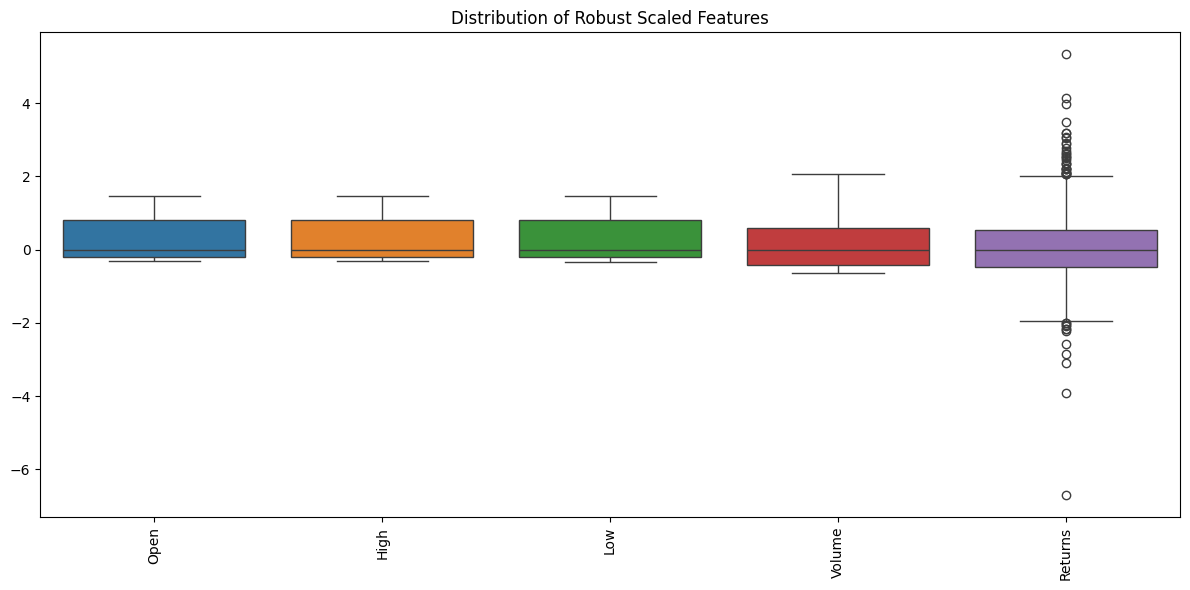

In [ ]:
# 7.6. Robust Scaling (for outlier-sensitive data)
print("\n7.6. Applying Robust Scaling")

# Initialize and fit scaler
robust_scaler = RobustScaler()
X_train_robust = pd.DataFrame(
    robust_scaler.fit_transform(df_treated),
    columns=df_treated.columns,
    index=df_treated.index
)

joblib.dump(robust_scaler, 'robust_scaler_features.pkl')

X_valid_robust = pd.DataFrame(
    robust_scaler.transform(X_valid),
    columns=X_valid.columns,
    index=X_valid.index
)


# Check the scaled data
print("Robust scaled training data statistics:")
print(X_train_robust.describe().T[['mean', 'std', 'min', 'max']].head())

cols_to_plot = X_train_robust.columns[:5]

# Visualize a sample of robust scaled features
plt.figure(figsize=(12, 6))
sns.boxplot(data=X_train_robust[cols_to_plot])
plt.title('Distribution of Robust Scaled Features')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Robust scaled training data statistics:
mean    0.303223
std     0.560433
min    -0.317198
max     1.451435
Name: Close, dtype: float64


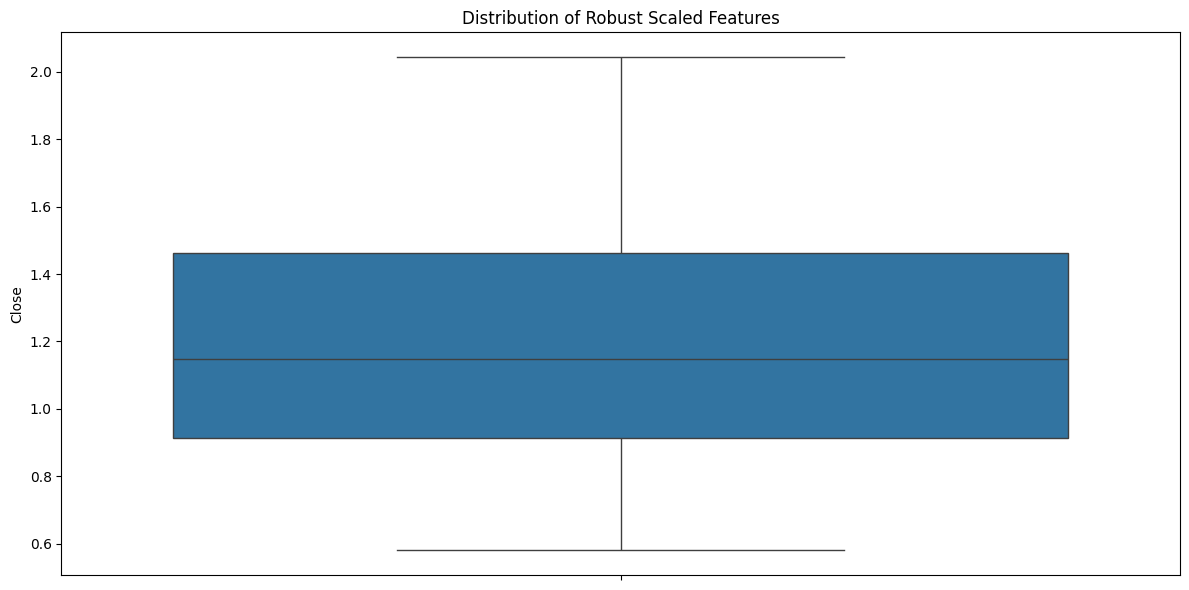

In [ ]:
# Create scaler for target
target_scaler = RobustScaler()

# Fit on y_train and transform both y_train and y_valid
y_train_robust = pd.Series(
    target_scaler.fit_transform(df_treated_c.values.reshape(-1, 1)).flatten(),
    index=df_treated_c.index,
    name='Close'
)

joblib.dump(target_scaler, 'target_scaler_close.pkl')

y_valid_robust = pd.Series(
    target_scaler.transform(y_valid.values.reshape(-1, 1)).flatten(),
    index=y_valid.index,
    name='Close'
)

# Check the scaled data
print("Robust scaled training data statistics:")
print(y_train_robust.describe().T[['mean', 'std', 'min', 'max']].head())

plt.figure(figsize=(12, 6))
sns.boxplot(data=y_valid_robust)
plt.title('Distribution of Robust Scaled Features')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# # 7.7. Compare scaling methods for a sample feature
# print("\n7.7. Comparing Scaling Methods")

# # Choose a feature with some outliers (e.g., Volume or a momentum feature)
# # For demonstration, let's take 'Volume' or a derived feature
# sample_feature = 'Volume' if 'Volume' in X_train.columns else X_train.columns[0]

# plt.figure(figsize=(15, 10))

# # Original data
# plt.subplot(2, 2, 1)
# plt.hist(X_train[sample_feature], bins=50)
# plt.title(f'Original {sample_feature}')

# # Standard scaled
# plt.subplot(2, 2, 2)
# plt.hist(X_train_std[sample_feature], bins=50)
# plt.title(f'Standard Scaled {sample_feature}')

# # Min-max scaled
# plt.subplot(2, 2, 3)
# plt.hist(X_train_minmax[sample_feature], bins=50)
# plt.title(f'Min-Max Scaled {sample_feature}')

# # Robust scaled
# plt.subplot(2, 2, 4)
# plt.hist(X_train_robust[sample_feature], bins=50)
# plt.title(f'Robust Scaled {sample_feature}')

# plt.tight_layout()
# plt.show()

In [ ]:
# 7.8. Check for potential issues after scaling
print("\n7.8. Checking for issues after scaling")

# Check for NaNs in scaled data
# print("NaN values after Standard scaling:", X_train_std.isna().sum().sum())
# print("NaN values after Min-Max scaling:", X_train_minmax.isna().sum().sum())
print("NaN values after Robust scaling in X_train:", X_train_robust.isna().sum().sum())
print("NaN values after Robust scaling in y_train:", y_train_robust.isna().sum().sum())
print("NaN values after Robust scaling in X_valid:", X_valid_robust.isna().sum().sum())
print("NaN values after Robust scaling in y_valid:", y_valid_robust.isna().sum().sum())



# Check for infinity values
# print("Infinity values after Standard scaling:", np.isinf(X_train_std).sum().sum())
# print("Infinity values after Min-Max scaling:", np.isinf(X_train_minmax).sum().sum())
print("Infinity values after Robust scaling in X_train:", np.isinf(X_train_robust).sum().sum())
print("Infinity values after Robust scaling in y_train:", np.isinf(y_train_robust).sum().sum())
print("Infinity values after Robust scaling in X_valid:", np.isinf(X_valid_robust).sum().sum())
print("Infinity values after Robust scaling in y_valid:", np.isinf(y_valid_robust).sum().sum())


7.8. Checking for issues after scaling
NaN values after Robust scaling in X_train: 0
NaN values after Robust scaling in y_train: 0
NaN values after Robust scaling in X_valid: 0
NaN values after Robust scaling in y_valid: 0
Infinity values after Robust scaling in X_train: 0
Infinity values after Robust scaling in y_train: 0
Infinity values after Robust scaling in X_valid: 0
Infinity values after Robust scaling in y_valid: 0


In [ ]:
# 7.9. Decide which scaling method to use based on the results
print("\n7.9. Scaling Method Recommendation")

# For cryptocurrency data with potential outliers, robust scaling is often preferable
print("Based on the visualization and feature characteristics:")
print("1. For features with normal distribution: Standard Scaling is appropriate")
print("2. For features with outliers: Robust Scaling is recommended")
print("3. For features that should be bounded between 0-1: Min-Max Scaling works best")

# For our crypto time series, a recommendation:
print("\nRECOMMENDATION:")
print("Since cryptocurrency data often contains outliers and extreme price movements,")
print("Robust Scaling is generally recommended as the primary scaling method.")
print("However, for certain models like neural networks that prefer inputs in [0,1],")
print("Min-Max scaling might be preferred.")


7.9. Scaling Method Recommendation
Based on the visualization and feature characteristics:
1. For features with normal distribution: Standard Scaling is appropriate
2. For features with outliers: Robust Scaling is recommended
3. For features that should be bounded between 0-1: Min-Max Scaling works best

RECOMMENDATION:
Since cryptocurrency data often contains outliers and extreme price movements,
Robust Scaling is generally recommended as the primary scaling method.
However, for certain models like neural networks that prefer inputs in [0,1],
Min-Max scaling might be preferred.


In [ ]:
# 7.10. Store the selected scaling method and scaled datasets for the next step
print("\n7.10. Saving the scaled datasets")

# For this example, we'll proceed with Robust Scaling as our primary method
X_train_scaled = X_train_robust.copy()
X_valid_scaled = X_valid_robust.copy()
y_train_scaled = y_train_robust.copy()
y_valid_scaled = y_valid_robust.copy()

# Store the scaler for future use (e.g., with test data or when making predictions)
# selected_scaler = robust_scaler

print(f"Selected scaling method: Robust Scaling")
print(f"Final training set shape: {X_train_scaled.shape}")
print(f"Final validation set shape: {X_valid_scaled.shape}")
print(f"Final training target shape: {y_train_scaled.shape}")
print(f"Final validation target shape: {y_valid_scaled.shape}")



7.10. Saving the scaled datasets
Selected scaling method: Robust Scaling
Final training set shape: (1093, 98)
Final validation set shape: (274, 98)
Final training target shape: (1093,)
Final validation target shape: (274,)


In [ ]:
X_train_scaled.to_csv('/content/drive/MyDrive/Crypto-data-v3/step7_X_train_scaled.csv', index=True, index_label='date')
print("\nScaled X_train dataset saved as 'step7_X_train_scaled.csv'")
X_valid_scaled.to_csv('/content/drive/MyDrive/Crypto-data-v3/step7_X_valid_scaled.csv', index=True, index_label='date')
print("\nScaled X_valid dataset saved as 'step7_X_valid_scaled.csv'")
y_train_scaled.to_csv('/content/drive/MyDrive/Crypto-data-v3/step7_y_train_scaled.csv', index=True, index_label='date')
print("\nScaled y_train dataset saved as 'step7_y_train_scaled.csv'")
y_valid_scaled.to_csv('/content/drive/MyDrive/Crypto-data-v3/step7_y_valid_scaled.csv', index=True, index_label='date')
print("\nScaled y_valid dataset saved as 'step7_y_valid_scaled.csv'")


Scaled X_train dataset saved as 'step7_X_train_scaled.csv'

Scaled X_valid dataset saved as 'step7_X_valid_scaled.csv'

Scaled y_train dataset saved as 'step7_y_train_scaled.csv'

Scaled y_valid dataset saved as 'step7_y_valid_scaled.csv'


# **Feature Selection**

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.decomposition import PCA

In [ ]:
# # 10.2. Filter-based feature selection (correlation)
# print("\n10.2. Filter-based feature selection (correlation)")

# # Calculate correlation with target
# correlation_with_target = X.corrwith(y).abs().sort_values(ascending=False)

# # Display top correlated features
# print("Top 20 features by correlation with target:")
# print(correlation_with_target.head(20))

# # Create a correlation threshold
# correlation_threshold = 0.3
# high_corr_features = correlation_with_target[correlation_with_target > correlation_threshold].index.tolist()
# print(f"\nFeatures with correlation > {correlation_threshold}: {len(high_corr_features)}")
# print(f"Sample high correlation features: {high_corr_features[:5]}{'...' if len(high_corr_features) > 5 else ''}")



# 10.2. Filter-based feature selection (correlation)
print("\n10.2. Filter-based feature selection (correlation)")

# Calculate correlation on X_train vs y_train (scaled)
correlation_with_target = X_train_scaled.corrwith(y_train_scaled.squeeze()).abs().sort_values(ascending=False)

# Show top correlated features
print("Top 20 features by correlation with target:")
print(correlation_with_target.head(20))

# Set a balanced threshold
correlation_threshold = 0.3
high_corr_features = correlation_with_target[correlation_with_target > correlation_threshold].index.tolist()
low_corr_features = correlation_with_target[correlation_with_target <= correlation_threshold]

print(f"\nFeatures with correlation > {correlation_threshold}: {len(high_corr_features)}")
print(f"Sample high correlation features: {high_corr_features[:5]}{'...' if len(high_corr_features) > 5 else ''}")


# Passed features
print(f"\n✅ Features with correlation > {correlation_threshold} ({len(high_corr_features)} total):")
for feature in high_corr_features:
    print(f"{feature}")

# Failed features
print(f"\n❌ Features with correlation <= {correlation_threshold} ({len(low_corr_features)} total):")
for feature in low_corr_features.items():
    print(f"{feature}")



10.2. Filter-based feature selection (correlation)
Top 20 features by correlation with target:
High                0.998727
Low                 0.998039
Open                0.996859
EMA_5               0.994471
Close_Lag_1         0.993548
SMA_5               0.993182
Close_Lag_2         0.990301
EMA_10              0.990183
Close_Lag_3         0.987281
SMA_10              0.987098
EMA_20              0.980298
Close_Lag_5         0.979347
Resistance_Level    0.979274
20d_High            0.979274
BB_Upper_20         0.975975
SMA_20              0.973956
BB_Middle_20        0.973956
Close_Lag_7         0.971513
Log_Close           0.959737
Support_Level       0.959423
dtype: float64

Features with correlation > 0.3: 51
Sample high correlation features: ['High', 'Low', 'Open', 'EMA_5', 'Close_Lag_1']...

✅ Features with correlation > 0.3 (51 total):
High
Low
Open
EMA_5
Close_Lag_1
SMA_5
Close_Lag_2
EMA_10
Close_Lag_3
SMA_10
EMA_20
Close_Lag_5
Resistance_Level
20d_High
BB_Upper_20
SMA_20


In [ ]:
# # 10.3. Mutual Information for non-linear relationships
# print("\n10.3. Mutual Information for non-linear relationships")

# # Calculate mutual information scores (handle possible errors)
# try:
#     X_scaled = StandardScaler().fit_transform(X)
#     mi_scores = mutual_info_regression(X_scaled, y)
#     mi_scores = pd.Series(mi_scores, index=X.columns)
#     mi_scores = mi_scores.sort_values(ascending=False)

#     # Display top features by mutual information
#     print("Top 20 features by mutual information:")
#     print(mi_scores.head(20))

#     # Select top features by mutual information
#     mi_threshold = np.percentile(mi_scores, 70)  # Top 30% of features
#     high_mi_features = mi_scores[mi_scores > mi_threshold].index.tolist()
#     print(f"\nTop 30% features by mutual information: {len(high_mi_features)}")
#     print(f"Sample high MI features: {high_mi_features[:5]}{'...' if len(high_mi_features) > 5 else ''}")
# except Exception as e:
#     print(f"Error calculating mutual information: {e}")
#     high_mi_features = []


# 10.3. Mutual Information for non-linear relationships
print("\n10.3. Mutual Information for non-linear relationships")

# Use already scaled X_train and y_train
try:
    mi_scores = mutual_info_regression(X_train_scaled, y_train_scaled.squeeze())
    mi_scores = pd.Series(mi_scores, index=X_train_scaled.columns).sort_values(ascending=False)

    # Display top features by MI
    print("Top 20 features by mutual information:")
    print(mi_scores.head(20))

    # Select top 40% features
    mi_threshold = np.percentile(mi_scores, 60)  # Keep top 40%
    high_mi_features = mi_scores[mi_scores > mi_threshold].index.tolist()
    low_mi_features = mi_scores[mi_scores <= mi_threshold]

    print(f"\n✅ Top 40% features by mutual information: {len(high_mi_features)}")
    for feature in high_mi_features:
        print(f"{feature}")

    print(f"\n❌ Features below 70th percentile threshold ({len(low_mi_features)}):")
    for feature in low_mi_features.items():
        print(f"{feature}")

except Exception as e:
    print(f"Error calculating mutual information: {e}")
    high_mi_features = []


10.3. Mutual Information for non-linear relationships
Top 20 features by mutual information:
Log_Close           5.013516
ATH_Drawdown        4.991578
High                3.118186
Low                 2.991183
EMA_5               2.596238
Close_Lag_1         2.533364
Open                2.532165
SMA_5               2.416745
EMA_10              2.197493
Close_Lag_2         2.179352
Resistance_Level    2.145569
20d_High            2.139102
SMA_10              2.053674
Close_Lag_3         1.996467
Support_Level       1.969245
20d_Low             1.966540
BB_Upper_20         1.949072
EMA_20              1.936654
BB_Middle_20        1.850798
SMA_20              1.850676
dtype: float64

✅ Top 40% features by mutual information: 39
Log_Close
ATH_Drawdown
High
Low
EMA_5
Close_Lag_1
Open
SMA_5
EMA_10
Close_Lag_2
Resistance_Level
20d_High
SMA_10
Close_Lag_3
Support_Level
20d_Low
BB_Upper_20
EMA_20
BB_Middle_20
SMA_20
Close_Lag_5
Close_Lag_7
Volume_SMA_100
Volume_SMA_200
EMA_50
BB_Lower_20
SMA_20

In [ ]:
# # 10.4. Combine feature selection methods
# print("\n10.4. Combining feature selection methods")

# # Combine high correlation and high mutual information features
# if high_mi_features:
#     selected_features = list(set(high_corr_features + high_mi_features))
# else:
#     selected_features = high_corr_features

# print(f"Combined selected features: {len(selected_features)}")

# # If we have too many features, apply SelectKBest
# max_features = 100  # Maximum number of features to keep
# if len(selected_features) > max_features:
#     print(f"\nToo many features ({len(selected_features)}). Reducing to {max_features} using SelectKBest")

#     # Apply SelectKBest
#     selector = SelectKBest(f_regression, k=max_features)
#     X_selected = selector.fit_transform(X[selected_features], y)

#     # Get selected feature names
#     selected_mask = selector.get_support()
#     selected_features = [selected_features[i] for i in range(len(selected_features)) if selected_mask[i]]

#     print(f"Final number of features after SelectKBest: {len(selected_features)}")


# 10.4. Combining feature selection methods
print("\n10.4. Combining feature selection methods")

# Combine high correlation and mutual information features
if high_mi_features:
    selected_features = list(set(high_corr_features + high_mi_features))
else:
    selected_features = high_corr_features

print(f"Combined selected features: {len(selected_features)}")

# Apply SelectKBest only if feature count is very high
max_features = 80  # TFT can handle this much
if len(selected_features) > max_features:
    print(f"\nToo many features ({len(selected_features)}). Reducing to {max_features} using SelectKBest")

    # Optional: You can test with mutual_info_regression instead of f_regression
    selector = SelectKBest(score_func=f_regression, k=max_features)
    X_K_selected = selector.fit_transform(X_train_scaled[selected_features], y_train_scaled)

    # Update selected feature names
    selected_mask = selector.get_support()
    selected_features = [selected_features[i] for i in range(len(selected_features)) if selected_mask[i]]

    print(f"Final number of features after SelectKBest: {len(selected_features)}")



10.4. Combining feature selection methods
Combined selected features: 52


In [ ]:
print(f"Selected features: {selected_features}")

Selected features: ['BB_Middle_20', 'Close_Lag_3', 'Volume_SMA_20', 'EMA_200', 'Volume_Lag_1', 'SMA_50_Above_SMA_200', 'MACD_Line', 'EMA_20', 'Close_Lag_7', 'SMA_50', 'Volume_Lag_5', 'Price_Above_SMA_200', 'Volume_SMA_100', 'Volume_SMA_50', 'Open', 'Volume_Lag_7', 'Volume_SMA_10', 'EMA_100', 'ATH_Drawdown', 'Volume_Lag_21', '20d_High', 'Close_Lag_1', 'Low', 'BB_Upper_20', 'Log_Volume', 'Volume_Lag_14', 'SMA_5', 'Close_Lag_21', 'Volume_Lag_3', 'SMA_20', 'EMA_10', 'Volume_SMA_200', 'Volume_SMA_5', '20d_Low', 'BB_Lower_20', 'Volume', 'ATR_14', 'SMA_200', 'EMA_5', 'Close_Lag_14', 'MACD_Signal', 'SMA_10', 'EMA_50', 'Resistance_Level', 'Close_Lag_2', 'Volume_Lag_2', 'Week_of_Year', 'High', 'SMA_100', 'Log_Close', 'Support_Level', 'Close_Lag_5']



10.5. Visualizing feature importance


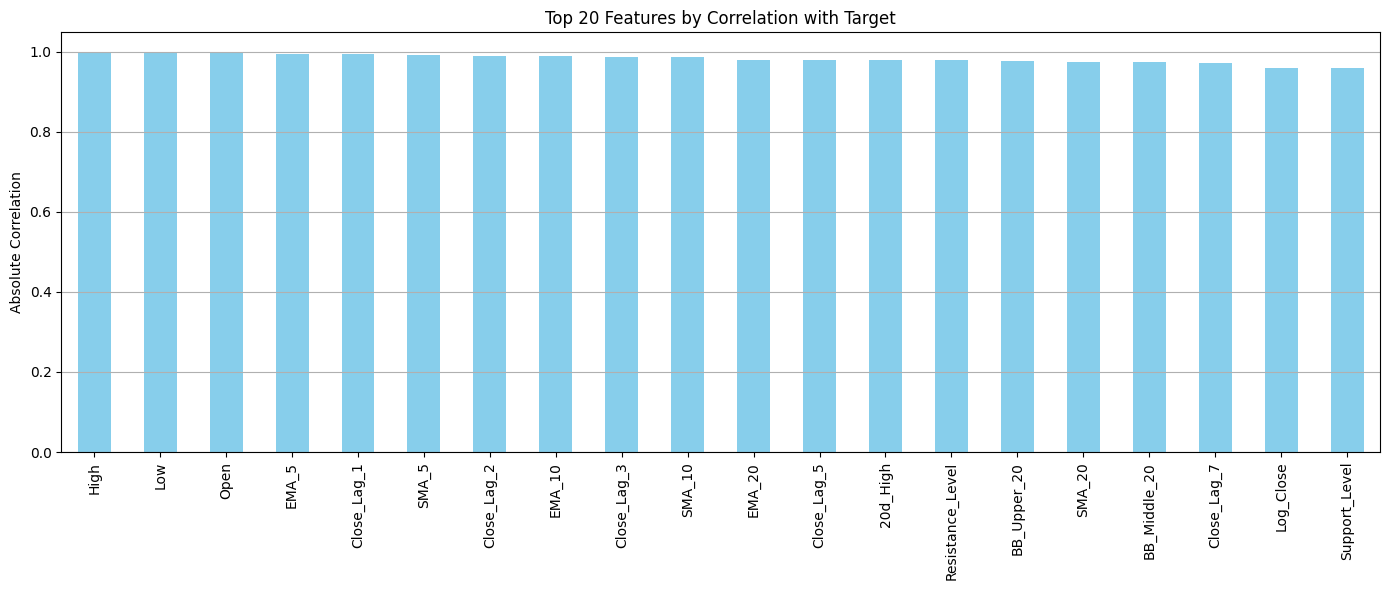

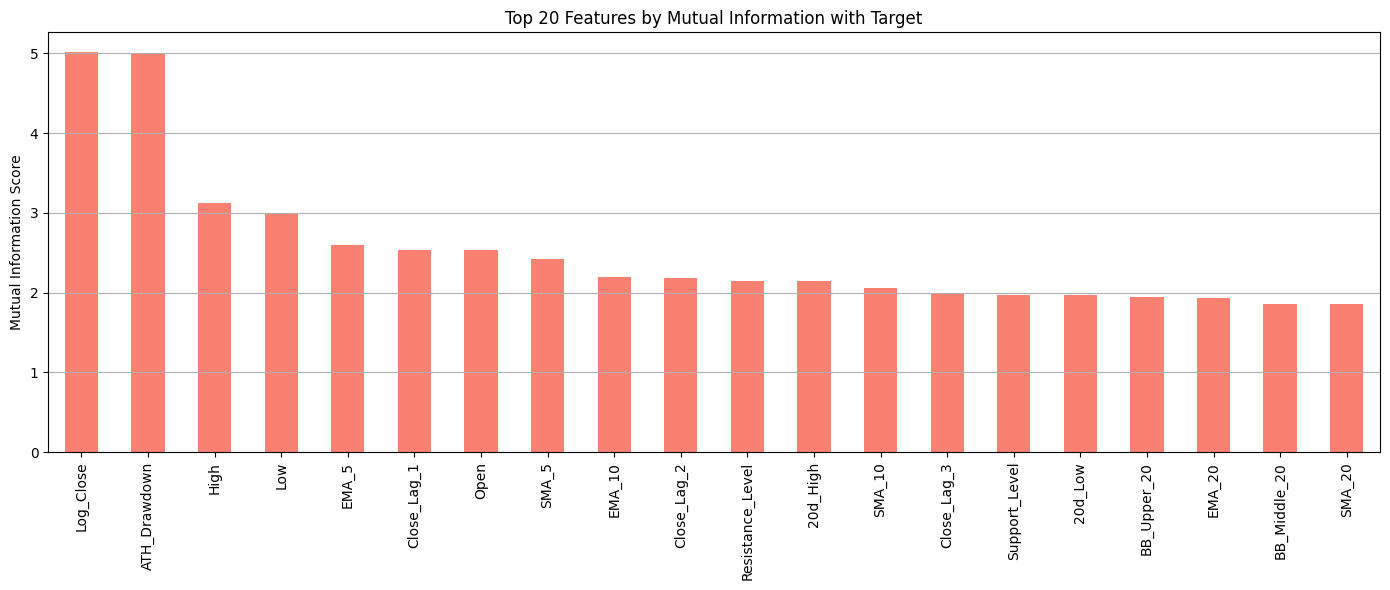

In [ ]:
# 10.5. Feature importance visualization
print("\n10.5. Visualizing feature importance")

# # Plot top 20 features by correlation
# plt.figure(figsize=(14, 8))
# correlation_with_target[selected_features].sort_values(ascending=False).head(20).plot(kind='bar')
# plt.title('Top 20 Features by Correlation with Target')
# plt.grid(True, axis='y')
# plt.tight_layout()
# plt.show()


# Top 20 by correlation
plt.figure(figsize=(14, 6))
correlation_with_target[selected_features].sort_values(ascending=False).head(20).plot(kind='bar', color='skyblue')
plt.title('Top 20 Features by Correlation with Target')
plt.ylabel('Absolute Correlation')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Top 20 by mutual information
plt.figure(figsize=(14, 6))
mi_scores[selected_features].sort_values(ascending=False).head(20).plot(kind='bar', color='salmon')
plt.title('Top 20 Features by Mutual Information with Target')
plt.ylabel('Mutual Information Score')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


In [ ]:
# 10.7. Apply selected features to both train and validation sets

print("\n10.7. Applying selected features to train and validation sets")

# Ensure consistent features across datasets
X_train_selected = X_train_scaled[selected_features].copy()
X_valid_selected = X_valid_scaled[selected_features].copy()

print(f"X_train_selected shape: {X_train_selected.shape}")
print(f"X_valid_selected shape: {X_valid_selected.shape}")
print(f"First 5 columns: {X_train_selected.columns[:5]}")
print(f"First 5 columns: {X_valid_selected.columns[:5]}")


10.7. Applying selected features to train and validation sets
X_train_selected shape: (1093, 52)
X_valid_selected shape: (274, 52)
First 5 columns: Index(['BB_Middle_20', 'Close_Lag_3', 'Volume_SMA_20', 'EMA_200',
       'Volume_Lag_1'],
      dtype='object')
First 5 columns: Index(['BB_Middle_20', 'Close_Lag_3', 'Volume_SMA_20', 'EMA_200',
       'Volume_Lag_1'],
      dtype='object')


In [ ]:
X_train_selected.to_csv('/content/drive/MyDrive/Crypto-data-v3/X_train_selected.csv', index=True, index_label='date')
print("\nSelected X_train dataset saved as 'X_train_selected.csv'")
X_valid_selected.to_csv('/content/drive/MyDrive/Crypto-data-v3/X_valid_selected.csv', index=True, index_label='date')
print("\nSelected X_valid dataset saved as 'X_valid_selected.csv'")


Selected X_train dataset saved as 'X_train_selected.csv'

Selected X_valid dataset saved as 'X_valid_selected.csv'


Currently your main Training datasets are : **X_train_selected, step7_y_train_scaled**

Currently your main Testing datasets are : **X_valid_selected, step7_y_valid_scaled**